<a href="https://colab.research.google.com/github/Alexandre77777/data_mining/blob/main/4.%20%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%20k-%D0%B1%D0%BB%D0%B8%D0%B6%D0%B0%D0%B8%CC%86%D1%88%D0%B8%D1%85%20%D1%81%D0%BE%D1%81%D0%B5%D0%B4%D0%B5%D0%B8%CC%86/%D0%A2%D0%B5%D0%BE%D1%80%D0%B8%D1%8F/%D0%A2%D0%B5%D0%BE%D1%80%D0%B8%D1%8F_%E2%84%966_%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_K_%D0%B1%D0%BB%D0%B8%D0%B6%D0%B0%D0%B8%CC%86%D1%88%D0%B8%D1%85_%D1%81%D0%BE%D1%81%D0%B5%D0%B4%D0%B5%D0%B8%CC%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Теория №6. Метод K ближайших соседей (KNN)

## KNN для классификации

### Литература

- [Ближайшие соседи - sklearn](http://scikit-learn.org/stable/modules/neighbors.html)
- [ODS классификация](https://habrahabr.ru/company/ods/blog/322534/#metod-blizhayshih-sosedey)
- [Семинары по машинному обучению, ВМК МГУ. kNN-1](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem02_knn.pdf)
- [Семинары по машинному обучению, ВМК МГУ. kNN-2](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem03_knn.pdf)

Начнем обсуждение с алгоритма kNN для задачи классификации. Расшифровывается его название как _"k ближайших соседей (k nearest neighbours)"_.

На изображении показано два класс (синие квадраты и красные треугольники), а в центре находится неопределившийся объект - зеленый круг, вот для него то и будем искать ближайших соседей.

 <img src='https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png'>


Идея алгоритма:

1. Взять новый объект и вычислить все расстояния по некоторой метрике от него до других объектов
2. Выбрать k ближайших соседей к этому объекту
3. Класс объекта - это класс наиболее часто встречающегося объекта среди k соседей.


 При инициализации алгоритмы KNN нужно указывать, на какое количество соседей вы хотите опираться, на изображении опираемся на трех ближайших соседей и видим, что два соседа имеют красный класс, а один сосед - синий класс, значит по большинству побеждает красный класс. И новый объект, зеленый круг, будет классифицирован, как красный треугольник.  

### Качество классификации методом ближайших соседей зависит от нескольких параметров:

- число соседей
- метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). Отметим, что при использовании большинства метрик значения признаков надо масштабировать. Условно говоря, чтобы признак "Зарплата" с диапазоном значений до 100 тысяч не вносил больший вклад в расстояние, чем "Возраст" со значениями до 100.
- веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос") - об этом поговорим позднее...

Модель очень ленивая, ведь вся суть её обучения сводится к запоминанию объектов из обучающей выборки.

Давайте обучим модель KNN из `sklearn` на сгенерированных данных.

Сгенерируем два класса с помощью функции `make_classification`.

In [ ]:
# Импортируем функцию make_classification из модуля sklearn.datasets
from sklearn.datasets import make_classification

# Создаем синтетический набор данных для задачи классификации
X, y = make_classification(
    n_samples=110,    # Общее количество генерируемых образцов
    n_features=2,     # Количество признаков (входных переменных)
    n_informative=2,  # Количество информативных признаков (в данном случае все признаки информативны)
    n_redundant=0,    # Количество избыточных признаков (в данном случае их нет)
    n_classes=2,      # Количество классов (бинарная классификация)
    random_state=6    # Зерно для воспроизводимости результатов
)

# Отображаем сгенерированные признаки (X) и целевые метки (y)
display(X, y)

array([[-1.71435607,  1.05793305],
       [ 1.22308043, -2.2635163 ],
       [-0.74339553, -0.82836749],
       [-3.10114999,  0.55737705],
       [-1.25272785, -1.99962916],
       [ 1.295549  , -0.90585939],
       [-0.39121512,  1.30843756],
       [-2.29436606, -0.32114685],
       [-0.37326143, -1.5106069 ],
       [ 0.84350362,  0.03804169],
       [-1.23337772,  0.62869299],
       [-0.51595847, -1.69033762],
       [ 0.11293492, -1.46417755],
       [ 0.39978471, -1.3120226 ],
       [-2.49684085, -0.0139064 ],
       [ 1.19899006,  1.27323302],
       [-1.84733371,  1.17918884],
       [-1.68009315,  0.94130391],
       [ 2.6400623 , -0.13810078],
       [-1.8453037 ,  0.96321745],
       [-0.71170663,  0.71554382],
       [-0.02934338, -1.59054511],
       [ 1.23158511,  1.36757795],
       [ 1.72196418, -0.7425116 ],
       [ 1.5719743 , -3.17595646],
       [ 0.14132289, -1.44743003],
       [ 1.80872881, -0.63583078],
       [ 1.79510491, -0.69260501],
       [ 0.07462334,

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0])

Разобьем выборку на обучение и тест с помощью `train_test_split`.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=10)
X_train.shape, X_test.shape

((100, 2), (10, 2))

И отрисуем полученные точки, синие - это один класс, оранжевые - это второй класс, а вот зеленые звезды - это тестовые точки, для них будет искать ближайших соседей.

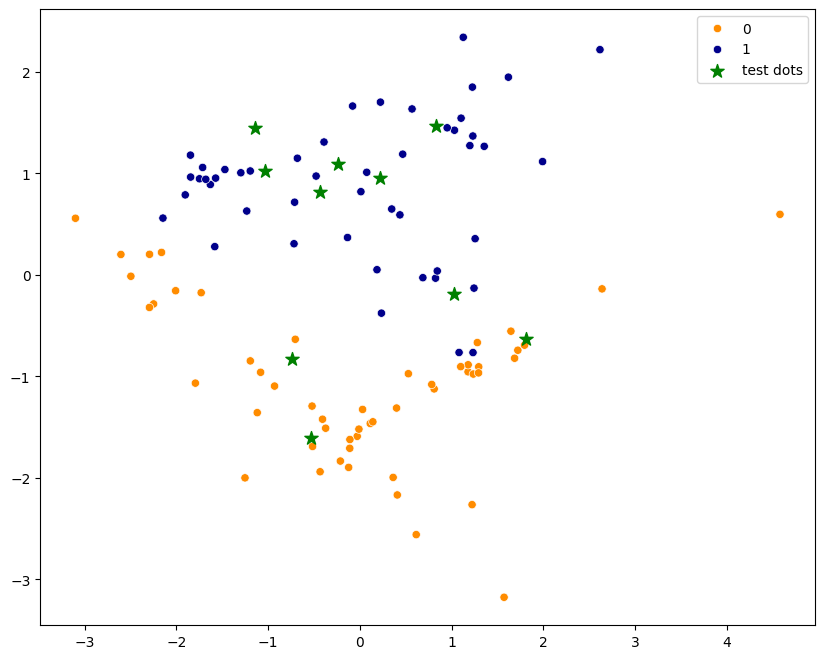

In [ ]:
# Импортируем необходимые библиотеки
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Создаем цветовую палитру для классов
cmap_bold = ["darkorange", "darkblue"]

# Создаем новую фигуру размером 10x8 дюймов
plt.figure(figsize=(10, 8))

# Визуализируем обучающие данные с помощью scatter plot
sns.scatterplot(
    x=X_train[:, 0],  # Первый признак для оси X
    y=X_train[:, 1],  # Второй признак для оси Y
    hue=y_train,      # Цвет точек зависит от класса
    palette=cmap_bold # Используем нашу цветовую палитру
)

# Добавляем тестовые точки на график
plt.scatter(
    X_test[:, 0],     # Первый признак тестовых данных для оси X
    X_test[:, 1],     # Второй признак тестовых данных для оси Y
    c='g',            # Зеленый цвет для тестовых точек
    marker='*',       # Используем звездочки для обозначения тестовых точек
    s=100,            # Размер маркеров
    label='test dots' # Метка для легенды
)

# Добавляем легенду на график
plt.legend()

### Обучение KNN

### sklearn.neighbors.KNeighborsClassifier

[Документация](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

Основные параметры класса sklearn.neighbors.KNeighborsClassifier:

- weights: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция
- algorithm (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем — расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автоматически на основе обучающей выборки.
- leaf_size (опционально): порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
- metric: "minkowski", "manhattan", "euclidean", "chebyshev" и другие

_взято из курса [ODS](https://habrahabr.ru/company/ods/blog/322534/#metod-blizhayshih-sosedey)_

Инициализируем модель `KNeighborsClassifier` для задачи классификации из `sklearn`.

In [ ]:
# Импортируем класс KNeighborsClassifier из модуля sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Устанавливаем количество соседей для алгоритма kNN
n_neighbors = 3

# Создаем экземпляр классификатора KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=n_neighbors)

И обучаем на обучающей выборке.

При этом помним, что никакого обучения нет, модель просто сохраняет выборку.

In [ ]:
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### Предсказание KNN

И теперь можем сделать предсказания для наших тестовых объектов.

In [ ]:
pred_test = model.predict(X_test)
pred_test

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 1])

И посмотрим, насколько предсказанные классы похожи на правду.

In [ ]:
display(pred_test, y_test)

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 1])

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 1])

Значения совпадают

#### Детали получения предсказания в KNN

А давайте увидем ближайших соседей для пары тестовых объектов.

Для этого
1. пройдемся по всем обучающим объектам
2. посчитаем Евклидово расстояние (ведь именно оно и считается по умолчанию в KNN в `sklearn`) через [`numpy.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html).

##### **Метрики расстояния:**

###### 1. Евклидова метрика

$\large \rho(x,y) = \sqrt{\sum_{i=1}^{n}{(x_i - y_i)^2}}$

###### 2. Манхэттенская метрика

$\large \rho(x,y) = \sum_{i=1}^{n}{|x_i - y_i|}$

######  3. Минковского метрика

$\large \rho(x,y) = {(\sum_{i=1}^{n}{|x_i - y_i| ^ q})} ^ \frac{1}{q}$

###### 4. Косинусная метрика

$\large \rho(x,y) = \arccos(\frac{\langle{x,y}\rangle}{\|x\|\|y\|}) = \arccos{\frac{\sum^d_{i=1}{x_i y_i}}{(\sum^d_{i=1}{x_i^2})^{1/2}(\sum^d_{i=1}{y_i^2})^{1/2}}}$

In [ ]:
import numpy as np
import pandas as pd

# Выбираем индекс тестовой точки
idx = 0
# Получаем тестовую точку по выбранному индексу
test_dot = X_test[idx]

# Создаем список для хранения данных о расстояниях
distances_data = []

# Проходим по всем точкам обучающего набора
for i, train_dot in enumerate(X_train):
    # Добавляем новую запись в список
    distances_data.append({
        'train_idx': i,
        'dst': np.linalg.norm(train_dot - test_dot, ord=2)
    })

# Создаем DataFrame из списка данных
distances = pd.DataFrame(distances_data)

И после подсчета всех расстояний от тестового объекта до обучающих объектов мы берем наиближайших, тех у которых расстояние меньше всех.

И возьмем только 3 соседей.

In [ ]:
distances.sort_values('dst').head(n_neighbors)

,train_idx,dst
40,40,0.159445
41,41,0.262930
15,15,0.375908


И получим их индексы для дальнейшей отрисовки.

In [ ]:
nearest_neigbors_idxs = distances.sort_values('dst').head(n_neighbors).index
nearest_neigbors_idxs

Index([40, 41, 15], dtype='int64')

Отрисовываем три найденных соседа в полупрозрачные зеленые окружности.

И видим, что действительно, эти три объекта самые близкие для данного тестового объекта и они все синего цвета, а значит по большинству побеждает именно синий класс.

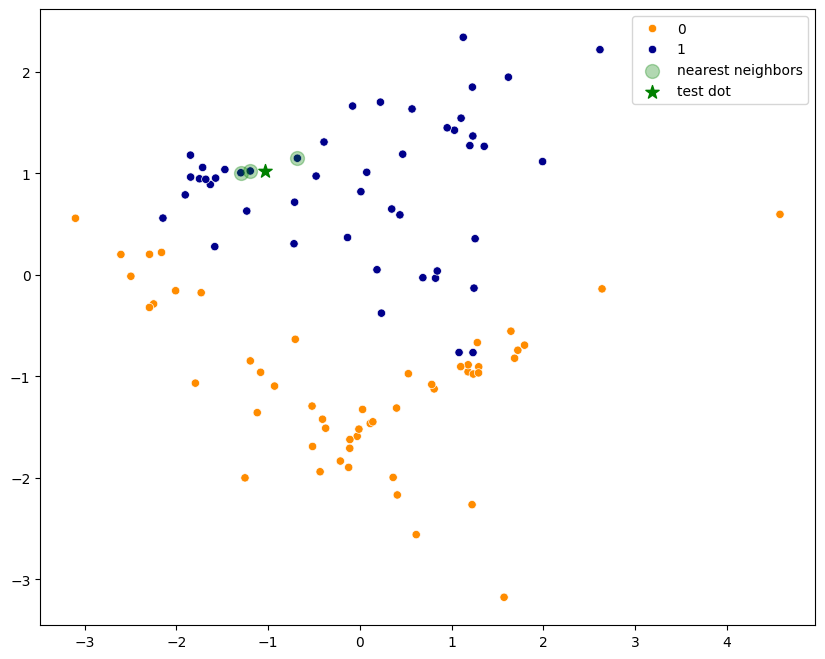

In [ ]:
# Создаем цветовую палитру для классов
cmap_bold = ["darkorange", "darkblue"]

# Создаем новую фигуру размером 10x8
plt.figure(figsize=(10, 8))

# Визуализируем обучающие данные с помощью scatter plot
sns.scatterplot(
    x=X_train[:, 0],  # Первый признак для оси X
    y=X_train[:, 1],  # Второй признак для оси Y
    hue=y_train,      # Цвет точек зависит от класса
    palette=cmap_bold # Используем нашу цветовую палитру
)

# Добавляем на график ближайших соседей
plt.scatter(X_train[nearest_neigbors_idxs, 0], X_train[nearest_neigbors_idxs, 1],
            c='g',            # Зеленый цвет для ближайших соседей
            alpha=0.3,        # Устанавливаем прозрачность
            marker='o',       # Используем круглые маркеры
            s=100,            # Размер маркеров
            label='nearest neighbors')  # Метка для легенды

# Добавляем тестовую точку на график
plt.scatter(X_test[idx, 0], X_test[idx, 1],
            c='g',            # Зеленый цвет для тестовой точки
            marker='*',       # Используем звездочку для обозначения тестовой точки
            s=100,            # Размер маркера
            label='test dot') # Метка для легенды

# Добавляем легенду на график
plt.legend()

А давайте возьмем еще один тестовый объект и сделаем для него точно такие же действия.

In [ ]:
import numpy as np
import pandas as pd

# Выбираем индекс тестовой точки
idx = 8
# Получаем тестовую точку по выбранному индексу
test_dot = X_test[idx]

# Создаем список для хранения данных о расстояниях
distances_data = []

# Проходим по всем точкам обучающего набора
for i, train_dot in enumerate(X_train):
    # Вычисляем евклидово расстояние между тестовой и обучающей точкой
    distance = np.linalg.norm(train_dot - test_dot, ord=2)
    # Добавляем индекс точки и расстояние в список
    distances_data.append({
        'train_idx': i,
        'dst': distance
    })

# Создаем DataFrame из списка данных
distances = pd.DataFrame(distances_data)

# Сортируем DataFrame по расстоянию и выбираем k ближайших соседей
nearest_neighbors = distances.sort_values('dst').head(n_neighbors)

И получае индексы для отрисовки.

In [ ]:
# Получаем индексы k ближайших соседей
nearest_neigbors_idxs = distances.sort_values('dst').head(n_neighbors).index

# Выводим индексы ближайших соседей
nearest_neigbors_idxs

Index([18, 75, 78], dtype='int64')

Отрисовываем три найденных соседа в полупрозрачные зеленые окружности.

И снова, эти три объекта самые близкие к тестовому объекту, а вот они все имеют метку оранжевого класса, а значит наш тестовый объект тоже приобретет метку "оранжевый класс".

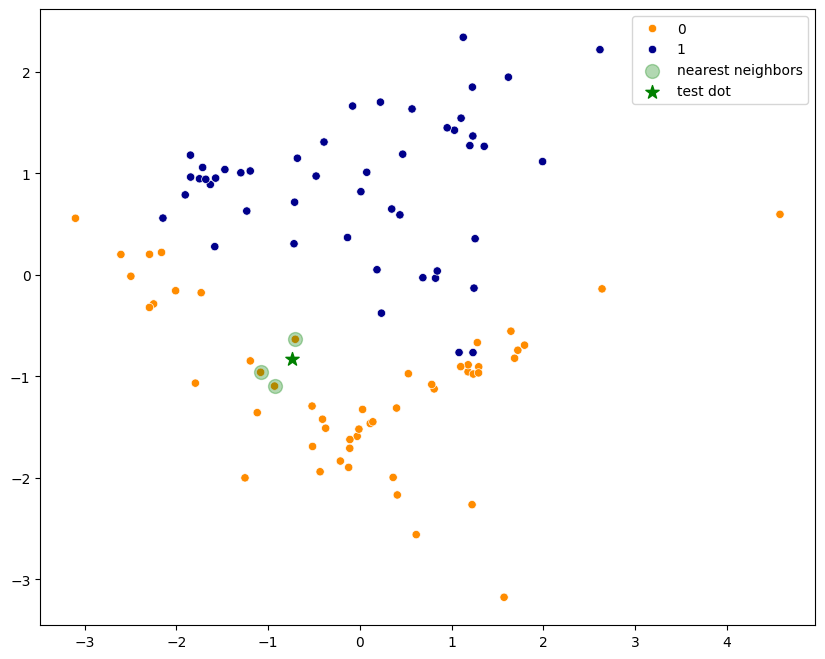

In [ ]:
# Создаем цветовую палитру для двух классов
cmap_bold = ["darkorange", "darkblue"]

# Создаем новую фигуру размером 10x8
plt.figure(figsize=(10, 8))

# Визуализируем все точки обучающего набора
sns.scatterplot(
    x=X_train[:, 0],  # Первый признак для оси X
    y=X_train[:, 1],  # Второй признак для оси Y
    hue=y_train,      # Цвет точек зависит от их класса
    palette=cmap_bold # Используем созданную цветовую палитру
)

# Добавляем на график k ближайших соседей
plt.scatter(X_train[nearest_neigbors_idxs, 0], X_train[nearest_neigbors_idxs, 1],
            c='g',            # Зеленый цвет для ближайших соседей
            alpha=0.3,        # Устанавливаем прозрачность
            marker='o',       # Используем круглые маркеры
            s=100,            # Размер маркеров
            label='nearest neighbors')  # Метка для легенды

# Добавляем тестовую точку на график
plt.scatter(X_test[idx, 0], X_test[idx, 1],
            c='g',            # Зеленый цвет для тестовой точки
            marker='*',       # Используем звездочку для обозначения тестовой точки
            s=100,            # Размер маркера
            label='test dot') # Метка для легенды

# Добавляем легенду на график
plt.legend()

### Выводы по KNN для задач классификации:

В этом и кроется вся суть алгоритма KNN.

На **моменте обучения** ничего интересного не происходит: все точки из обучения попросту запоминаются.

На **моменте предсказания** происходят более интересные вещи:
1. для тестовой точки считаем расстояния до всех точек с обучения
2. сортируем от самого ближнего до самого дальнего расстояния
3. делаем голосование между классами ближайших $N$ соседей - это и есть предсказанная метка класса

## KNN для регрессии

А теперь давайте обсудим отличия KNN для классификации от KNN для регрессии.

Давайте обучим модель KNN для регресии из `sklearn` на сгенерированных данных.

Сгенерируем 110 объектов с помощью функции `make_regression`.

In [ ]:
# Импортируем функцию make_regression из модуля sklearn.datasets
from sklearn.datasets import make_regression

# Генерируем синтетический набор данных для задачи регрессии
X, y = make_regression(
    n_samples=110,    # Общее количество генерируемых образцов
    n_features=2,     # Количество признаков (входных переменных)
    n_informative=2,  # Количество информативных признаков
    random_state=6    # Зерно для воспроизводимости результатов
)

# Отображаем сгенерированные признаки (X) и целевые значения (y)
display(X, y)

array([[ 0.78263039, -0.49341854],
       [-0.18765745, -1.4863921 ],
       [ 1.63929108, -0.4298936 ],
       [ 0.35480861,  1.81259031],
       [-2.12647459,  0.75144883],
       [ 1.56448966,  0.71270509],
       [ 0.65725757, -0.47237563],
       [ 0.07409773,  2.03076035],
       [-0.12673638, -1.36861282],
       [-0.46550831,  0.23371059],
       [-1.22257572,  0.8228126 ],
       [ 0.11660197, -0.68225732],
       [ 0.64330145, -0.44789505],
       [-0.53070072,  1.13694227],
       [ 0.17365335, -1.03543429],
       [-0.96813764,  0.16706673],
       [-0.33588161,  1.23773784],
       [ 1.21848065, -0.85750144],
       [ 0.17629034,  1.09462041],
       [-0.50426698,  1.05250993],
       [-0.04723705, -1.44903979],
       [ 1.46901739,  1.74951635],
       [-0.03618977, -0.09084699],
       [ 0.82465384, -1.17643148],
       [-0.47144628,  2.33660781],
       [ 0.11444143, -0.02195668],
       [-0.06009261, -0.56848829],
       [ 0.31508564, -1.0146655 ],
       [-0.05961756,

array([ -10.66244648,  -92.07211428,   13.26158326,  115.24501892,
         -5.77482665,   78.87831107,  -12.37461469,  121.49849425,
        -83.69176519,    2.81713379,   19.72411478,  -37.48598927,
        -11.25972977,   54.54481088,  -56.96890099,  -12.9518793 ,
         65.07750333,  -21.86615914,   68.70174093,   50.18849411,
        -86.56196733,  137.7699071 ,   -6.20963507,  -49.94963378,
        126.68433272,    1.40080308,  -34.93897749,  -52.41284413,
         10.04578784,  -11.13189271,  -29.61021615,   97.11972486,
        -92.67858277,   71.76516307,   10.23353984,   73.10728639,
         35.64526282,  -55.44024142,  -99.30796032,  -29.72429363,
        -41.20631185,    9.81536928,  -95.31048751,    0.28292736,
         18.07617282,  -49.30635516,  -74.17129949,  -28.4343354 ,
        -34.66741029,   58.26901278,   74.61692388,   39.03528174,
         49.5828809 ,   -7.59293348,  -42.52180903,   66.94943122,
         -1.49989836,  -30.176389  ,   48.46334221,   44.36209

Разобьем выборку на обучение и тест с помощью `train_test_split`.

In [ ]:
# Импортируем функцию train_test_split из модуля sklearn.model_selection
from sklearn.model_selection import train_test_split

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,              # Матрица признаков
    y,              # Вектор целевых значений
    random_state=10,# Фиксируем генератор случайных чисел для воспроизводимости
    test_size=10    # Размер тестовой выборки (10 образцов)
)

# Выводим размерности полученных выборок
X_train.shape, X_test.shape

((100, 2), (10, 2))

И отрисуем полученные точки, раскрасим их в зависимости от целевого значения, если точка более яркая, то значит у неё большое целевое значение, если точка более блеклая, то и целевое значение меньше.

А зеленые звезды - это тестовые точки, для них будет искать ближайших соседей.

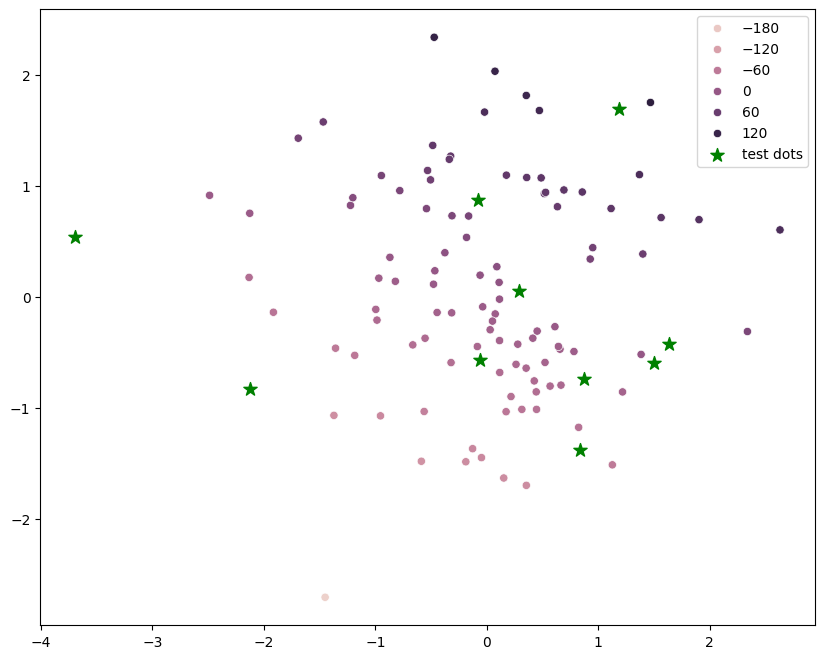

In [ ]:
# Создаем новую фигуру размером 10x8 дюймов
plt.figure(figsize=(10, 8))

# Визуализируем обучающие данные с помощью scatter plot
sns.scatterplot(
    x=X_train[:, 0],  # Первый признак для оси X
    y=X_train[:, 1],  # Второй признак для оси Y
    hue=y_train       # Цвет точек зависит от целевого значения
)

# Добавляем тестовые точки на график
plt.scatter(X_test[:, 0], X_test[:, 1],
            c='g',            # Зеленый цвет для тестовых точек
            marker='*',       # Используем звездочки для обозначения тестовых точек
            s=100,            # Размер маркеров
            label='test dots') # Метка для легенды

# Добавляем легенду на график
plt.legend()

### Обучение KNN

Инициализируем модель `KNeighborsRegressor` для задачи регрессии из `sklearn`.

In [ ]:
# Импортируем класс KNeighborsRegressor из модуля sklearn.neighbors
from sklearn.neighbors import KNeighborsRegressor

# Устанавливаем количество соседей для алгоритма kNN
n_neighbors = 3

# Создаем экземпляр регрессора KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=n_neighbors)

И обучаем на обучающей выборке.

Никакого обучения здесь нет, на самом деле, модель просто сохраняет выборку.

In [ ]:
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

### Предсказание KNN

И теперь можем сделать предсказания для наших тестовых объектов.

In [ ]:
pred_test = model.predict(X_test)
pred_test

array([-53.99812541, -25.33424853, -28.83554665, -10.18245823,
        47.79409516, 114.96770525, -16.82251686,   9.90350525,
         5.5775676 , -69.31157808])

И посмотрим, насколько предсказанные классы похожи на правду.

In [ ]:
display(pred_test, y_test)

array([-53.99812541, -25.33424853, -28.83554665, -10.18245823,
        47.79409516, 114.96770525, -16.82251686,   9.90350525,
         5.5775676 , -69.31157808])

array([-61.56318468, -23.01956535, -34.93897749,   0.28292736,
        49.5828809 , 127.67174326, -55.44024142,   9.81536928,
        13.26158326, -99.30796032])

Они конечно совпадают неидеально, но в целом они имеют близкие значения.

#### Детали получения предсказания в KNN

А давайте увидем ближайших соседей для пары тестовых объектов.

Для этого
1. пройдемся по всем обучающим объектам
2. посчитаем Евклидово расстояние (ведь именно оно и считается по умолчанию в KNN в `sklearn`) через `numpy.linalg.norm`.

In [ ]:
import numpy as np
import pandas as pd

# Выбираем индекс тестовой точки
idx = 0
# Получаем тестовую точку по выбранному индексу
test_dot = X_test[idx]

# Создаем список для хранения данных о расстояниях
distances_data = []

# Проходим по всем точкам обучающего набора
for i, train_dot in enumerate(X_train):
    # Вычисляем евклидово расстояние между тестовой и обучающей точкой
    distance = np.linalg.norm(train_dot - test_dot, ord=2)
    # Добавляем индекс точки и расстояние в список
    distances_data.append({
        'train_idx': i,
        'dst': distance
    })

# Создаем DataFrame из списка данных
distances = pd.DataFrame(distances_data)

И после подсчета всех расстояний от тестового объекта до обучающих объектов мы берем наиближайших, тех у которых расстояние меньше всех.

И возьмем только 3 соседей.

In [ ]:
distances.sort_values('dst').head(n_neighbors)

,train_idx,dst
60,60,0.202009
34,34,0.320839
32,32,0.532766


И получим их индексы для дальнейшей отрисовки.

In [ ]:
nearest_neigbors_idxs = distances.sort_values('dst').head(n_neighbors).index
nearest_neigbors_idxs

Index([60, 34, 32], dtype='int64')

Отрисовываем три найденных соседа в полупрозрачные зеленые окружности.

И видим, что действительно, эти три объекта самые близкие для данного тестового объекта и они имеют свои три целевых значения.

Чтобы получить предсказания для тестового объекта, нужно усреднить целевые значения ближайших соседей.

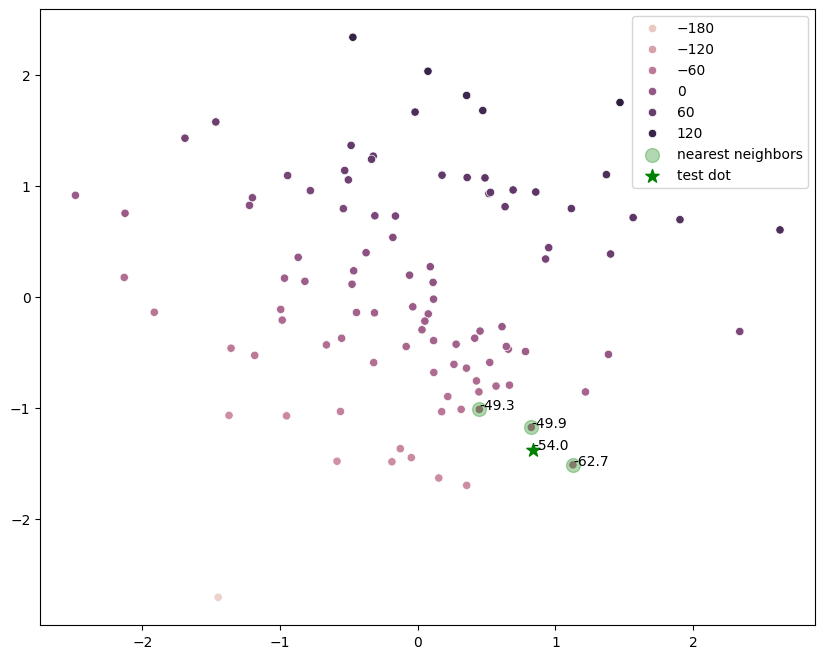

In [ ]:
# Создаем новую фигуру размером 10x8 дюймов
plt.figure(figsize=(10, 8))

# Визуализируем все точки обучающего набора
sns.scatterplot(
    x=X_train[:, 0],  # Первый признак для оси X
    y=X_train[:, 1],  # Второй признак для оси Y
    hue=y_train,      # Цвет точек зависит от их целевого значения
)

# Добавляем на график k ближайших соседей
plt.scatter(X_train[nearest_neigbors_idxs, 0], X_train[nearest_neigbors_idxs, 1],
            c='g',            # Зеленый цвет для ближайших соседей
            alpha=0.3,        # Устанавливаем прозрачность
            marker='o',       # Используем круглые маркеры
            s=100,            # Размер маркеров
            label='nearest neighbors')  # Метка для легенды

# Вычисляем предсказание как среднее значение целевых значений k ближайших соседей
pred = np.mean(y_train[nearest_neigbors_idxs])

# Добавляем тестовую точку на график
plt.scatter(X_test[idx, 0], X_test[idx, 1],
            c='g',            # Зеленый цвет для тестовой точки
            marker='*',       # Используем звездочку для обозначения тестовой точки
            s=100,            # Размер маркера
            label='test dot') # Метка для легенды

# Подписываем предсказанное значение для тестовой точки
plt.annotate(round(pred, 1), (X_test[idx, 0], X_test[idx, 1]))

# Подписываем целевые значения для каждого из k ближайших соседей
for i, txt in enumerate(y_train[nearest_neigbors_idxs]):
    plt.annotate(round(txt, 1), (X_train[nearest_neigbors_idxs[i], 0], X_train[nearest_neigbors_idxs[i], 1]))

# Добавляем легенду на график
plt.legend()

А давайте возьмем еще один тестовый объект и сделаем для него точно такие же действия.

In [ ]:
# Выбираем индекс тестовой точки
idx = 8
# Получаем тестовую точку по выбранному индексу
test_dot = X_test[idx]

# Создаем список для хранения данных о расстояниях
distances_data = []

# Проходим по всем точкам обучающего набора
for i, train_dot in enumerate(X_train):
    # Вычисляем евклидово расстояние между тестовой и обучающей точкой
    distance = np.linalg.norm(train_dot - test_dot, ord=2)
    # Добавляем индекс точки и расстояние в список
    distances_data.append({
        'train_idx': i,
        'dst': distance
    })

# Создаем DataFrame из списка данных
distances = pd.DataFrame(distances_data)

# Сортируем DataFrame по расстоянию и выбираем k ближайших соседей
nearest_neighbors = distances.sort_values('dst').head(n_neighbors)

И получае индексы для отрисовки.

In [ ]:
nearest_neigbors_idxs = distances.sort_values('dst').head(n_neighbors).index
nearest_neigbors_idxs

Index([54, 53, 17], dtype='int64')

Отрисовываем три найденных соседа в полупрозрачные зеленые окружности.

И снова, эти три объекта самые близкие к тестовому объекту.

А чтобы получить предсказание для звездочки, нужно усреднить их предсказанные целевые значения.

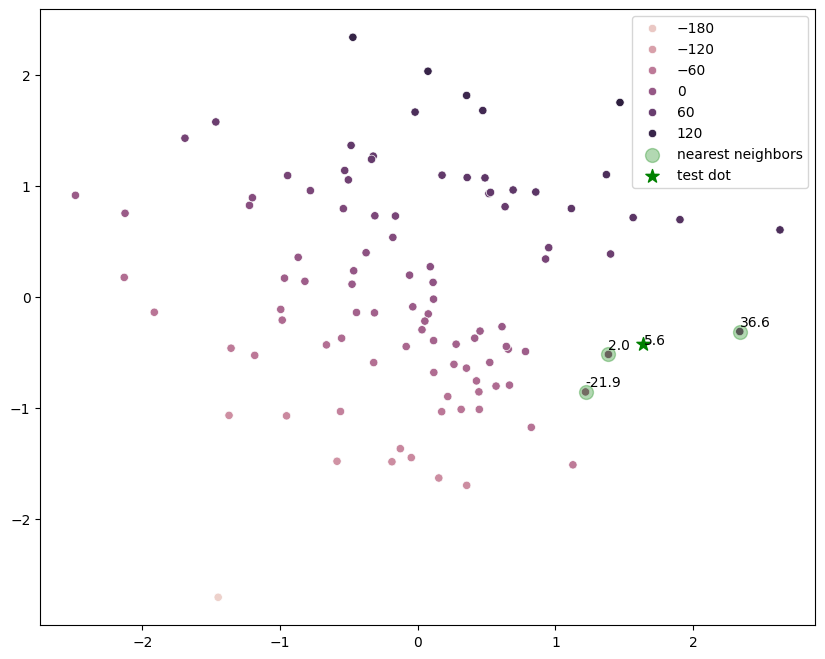

In [ ]:
# Создаем новую фигуру размером 10x8 дюймов
plt.figure(figsize=(10, 8))

# Создаем scatter plot для всех точек обучающего набора
# x-координаты - первый признак, y-координаты - второй признак
# Цвет точек зависит от целевой переменной y_train
sns.scatterplot(
    x=X_train[:, 0],
    y=X_train[:, 1],
    hue=y_train,
)

# Выделяем k ближайших соседей зеленым цветом
plt.scatter(X_train[nearest_neigbors_idxs, 0], X_train[nearest_neigbors_idxs, 1],
            c='g', alpha=0.3, marker='o', s=100, label='nearest neighbors')

# Вычисляем предсказание как среднее значение целевой переменной k ближайших соседей
pred = np.mean(y_train[nearest_neigbors_idxs])

# Отображаем тестовую точку зеленой звездочкой
plt.scatter(X_test[idx, 0], X_test[idx, 1], c='g', marker='*', s=100, label='test dot')

# Подписываем тестовую точку предсказанным значением
plt.annotate(round(pred, 1), (X_test[idx, 0], X_test[idx, 1]))

# Подписываем каждого из k ближайших соседей их фактическим значением целевой переменной
for i, txt in enumerate(y_train[nearest_neigbors_idxs]):
    plt.annotate(round(txt, 1), (X_train[nearest_neigbors_idxs[i], 0], X_train[nearest_neigbors_idxs[i], 1] + 0.05))

# Добавляем легенду на график
plt.legend();

### Выводы по KNN для регрессии:

С моделью для задачи регрессии всё тоже самое:

На **моменте обучения** ничего интересного не происходит: все точки из обучения попросту запоминаются.

На **моменте предсказания**:
1. для тестовой точки считаем расстояния до всех точек с обучения
2. сортируем от самого ближнего до самого дальнего расстояния
3. делаем усреднение целевых значений ближайших $N$ соседей - это и есть предсказание модели

## Как выбрать оптимальное количество соседей

А здесь нет четкого алгоритма, как нужно действовать, чтобы найти самое лучшее количество соседей, главное, не бросаться в крайности и смотреть на качество предсказания модели.


### Слишком мало соседей

Если взять слишком мало ближайших соседей (N < 3), то на предсказания могут влиять выбросные  объекты, либо предсказания вообще могут оказаться случайными.

Возьмем только одного ближайшего соседа.

In [ ]:
n_neighbors = 1

nearest_neigbors_idxs = distances.sort_values('dst').head(n_neighbors).index
nearest_neigbors_idxs

Index([54], dtype='int64')

И отрисуем его целевое значение и предсказание для тестового объекта.

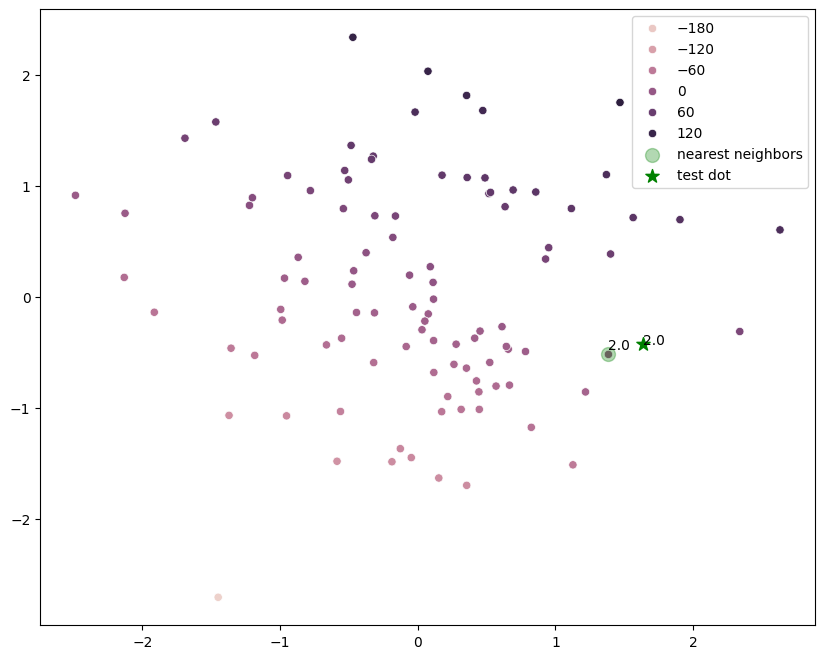

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_train[:, 0],
    y=X_train[:, 1],
    hue=y_train,
)

plt.scatter(X_train[nearest_neigbors_idxs, 0], X_train[nearest_neigbors_idxs, 1],
            c='g', alpha=0.3, marker='o', s=100, label='nearest neighbors')

pred = np.mean(y_train[nearest_neigbors_idxs])
plt.scatter(X_test[idx, 0], X_test[idx, 1], c='g', marker='*', s=100, label='test dot')
plt.annotate(round(pred, 1), (X_test[idx, 0], X_test[idx, 1]))

for i, txt in enumerate(y_train[nearest_neigbors_idxs]):
    plt.annotate(round(txt, 1), (X_train[nearest_neigbors_idxs[i], 0], X_train[nearest_neigbors_idxs[i], 1] + 0.05))

plt.legend();

### Слишком много соседей

А если взять слишком большое количество ближайших соседей для задачи, то предсказания будут сильно усредненными, все объекты могут влиять на предсказания нового объекта.

Возьмем 50 соседей, половина нашей выборки.

In [ ]:
n_neighbors = 50

nearest_neigbors_idxs = distances.sort_values('dst').head(n_neighbors).index
nearest_neigbors_idxs

Index([54, 53, 17, 55, 89, 31, 68, 25, 38, 18, 60, 23,  1, 80, 43, 49, 20, 34,
       15,  0, 13, 70, 32, 12, 14,  6, 21, 63, 50, 67, 85, 66, 72, 58, 11, 75,
       33, 83,  8, 37, 76, 44, 61,  9, 40, 48, 19, 95, 39, 46],
      dtype='int64')

И отрисуем, выходит, что каждый второй влияет на предсказание нового объекта.

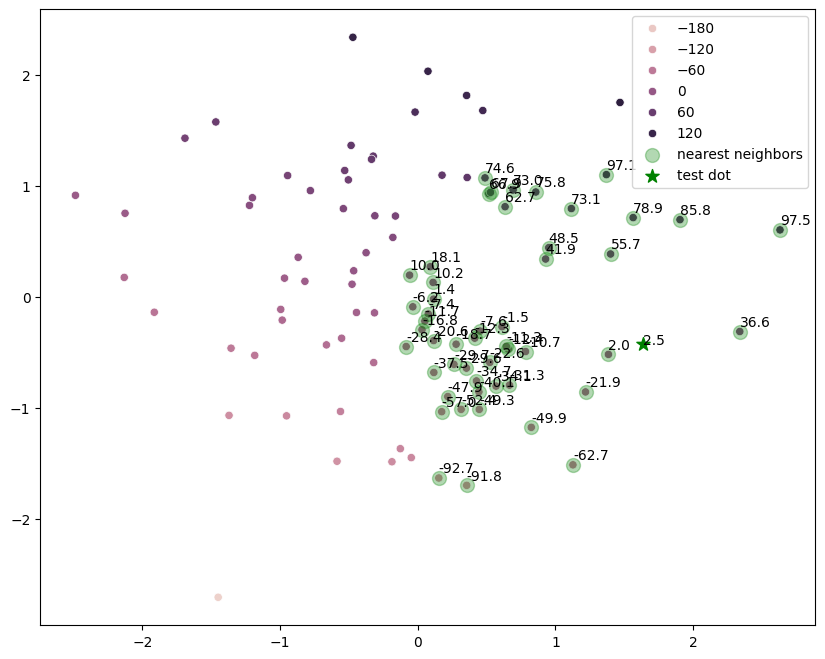

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_train[:, 0],
    y=X_train[:, 1],
    hue=y_train,
)

plt.scatter(X_train[nearest_neigbors_idxs, 0], X_train[nearest_neigbors_idxs, 1],
            c='g', alpha=0.3, marker='o', s=100, label='nearest neighbors')

pred = np.mean(y_train[nearest_neigbors_idxs])
plt.scatter(X_test[idx, 0], X_test[idx, 1], c='g', marker='*', s=100, label='test dot')
plt.annotate(round(pred, 1), (X_test[idx, 0], X_test[idx, 1]))

for i, txt in enumerate(y_train[nearest_neigbors_idxs]):
    plt.annotate(round(txt, 1), (X_train[nearest_neigbors_idxs[i], 0], X_train[nearest_neigbors_idxs[i], 1] + 0.05))

plt.legend();

Поэтому есть модификация - взвешенный KNN, речь о которой пойдет чуть позже


## Итог:

1. Модель и для регрессии, и для классификации **обучается** одинаково - **никак**, она запоминает обучающую выборку.
2. Затем поступает тестовый объект и нужно сделать предсказание
    - Считаем **расстояния до** всех объектов с **обучения**
    - Выбираем **K** ближайших
    - И в зависимости от задачи выдаем финальное предсказание
        1. ***Классификация***
            - Делаем **голосование** между соседями, за какой класс больше голосов, то и выбираем
        2. ***Регрессия***
            - Далем **усреденение** всех целевых значений

# Метод K взвешенных ближайших соседей (KNN)


## Зачем нужен взвешенный *KNN* для классификации

Чтобы это понять, давайте для начала быстро вспомним, в чем суть модели *KNN*:

Расшифровывается название как _"k ближайших соседей (k nearest neighbours)"_.

- Обучения нет, модель запоминает обучающую выборку
- На моменте предсказания
    1. Считаем **расстояния** до всех объектов с **обучения**
    2. Выбираем **K** ближайших
    3. Делаем **голосование** между соседами, за какой класс больше голосов, тот и выбираем


 <img src='https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png'>


Давайте обучим модель KNN из `sklearn` на сгенерированных данных.

Сгенерируем два класса с помощью функции `make_moons`.

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=50, random_state=6)

display(X, y)

array([[ 2.00000000e+00,  5.00000000e-01],
       [ 1.38268343e+00, -4.23879533e-01],
       [ 1.13052619e+00, -4.91444861e-01],
       [-9.91444861e-01,  1.30526192e-01],
       [ 6.08761429e-01,  7.93353340e-01],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 7.07106781e-01,  7.07106781e-01],
       [ 6.17316568e-01, -4.23879533e-01],
       [-2.58819045e-01,  9.65925826e-01],
       [ 2.92893219e-01, -2.07106781e-01],
       [ 1.99144486e+00,  3.69473808e-01],
       [-1.00000000e+00,  1.22464680e-16],
       [-7.93353340e-01,  6.08761429e-01],
       [ 9.23879533e-01,  3.82683432e-01],
       [ 1.50000000e+00, -3.66025404e-01],
       [ 7.61204675e-02,  1.17316568e-01],
       [ 1.70710678e+00, -2.07106781e-01],
       [ 2.06646660e-01, -1.08761429e-01],
       [ 1.96592583e+00,  2.41180955e-01],
       [-6.08761429e-01,  7.93353340e-01],
       [-9.23879533e-01,  3.82683432e-01],
       [ 1.33974596e-01,  0.00000000e+00],
       [ 1.25881905e+00, -4.65925826e-01],
       [-7.

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0])

Разобьем выборку на обучение и тест с помощью `train_test_split`.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6, test_size=5)
X_train.shape, X_test.shape

((45, 2), (5, 2))

И отрисуем полученные точки, синие - это один класс, оранжевые - это второй класс, а вот зеленые звезды - это тестовые точки, для них будет искать ближайших соседей.

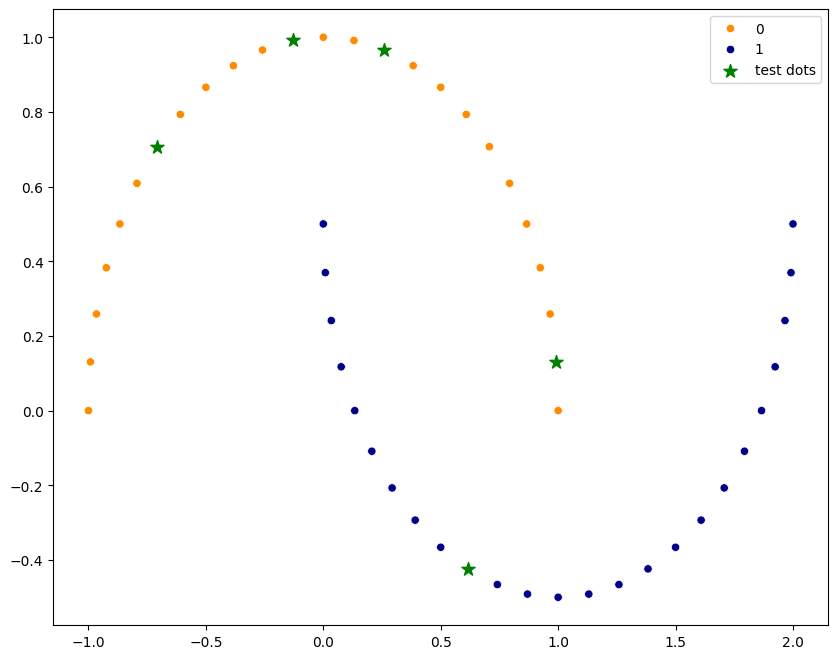

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create color maps
cmap_bold = ["darkorange", "darkblue"]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_train[:, 0],
    y=X_train[:, 1],
    hue=y_train,
    palette=cmap_bold
)

plt.scatter(X_test[:, 0], X_test[:, 1], c='g', marker='*', s=100, label='test dots')
plt.legend();

Обучим модель `KNeighborsClassifier` для задачи классификации из `sklearn`.

Укажем, что хотим слышать мнение 20 соседей, для нашей задачи из 50 объектов - это много соседей, но давайте пока обучимся так и посмотрим, а действительно ли 20 - это плохое количество соседей.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 20
model = KNeighborsClassifier(n_neighbors=n_neighbors)

In [ ]:
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

И теперь можем сделать предсказания для наших тестовых объектов.

In [ ]:
pred_test = model.predict(X_test)
pred_test

array([0, 1, 0, 0, 1])

И посмотрим, насколько предсказанные классы похожи на правду.

In [ ]:
display(pred_test, y_test)

array([0, 1, 0, 0, 1])

array([0, 0, 0, 0, 1])

Не совпали для одной точки, возможно для неё мы и переборщили с количеством соседей.

#### Детали получения предсказания в KNN

Получим ближайших соседей для парочки тестовых объектов.

In [ ]:
import numpy as np
import pandas as pd

# Выбираем индекс тестовой точки
idx = 0
# Получаем тестовую точку из тестового набора данных
test_dot = X_test[idx]

# Создаем список для хранения расстояний
distances_data = []

# Проходим по всем точкам обучающего набора
for i, train_dot in enumerate(X_train):
    # Вычисляем евклидово расстояние между тестовой и обучающей точкой
    distance = np.linalg.norm(train_dot - test_dot, ord=2)
    # Добавляем индекс точки и расстояние в список
    distances_data.append({
        'train_idx': i,
        'dst': distance
    })

# Создаем DataFrame из списка расстояний
distances = pd.DataFrame(distances_data)

И получим их индексы для дальнейшей отрисовки.

In [ ]:
nearest_neigbors_idxs = distances.sort_values('dst').head(n_neighbors).index
nearest_neigbors_idxs

Index([5, 17, 31, 4, 30, 1, 28, 9, 20, 24, 21, 16, 42, 40, 39, 33, 7, 15, 23,
       14],
      dtype='int64')

Отрисовываем 20 найденных соседей в полупрозрачные зеленые окружности.

Видим, что здесь нам повезло и большинство соседей являются оранжевым классом, именно представителем этого класса и является наш тестовый объект.

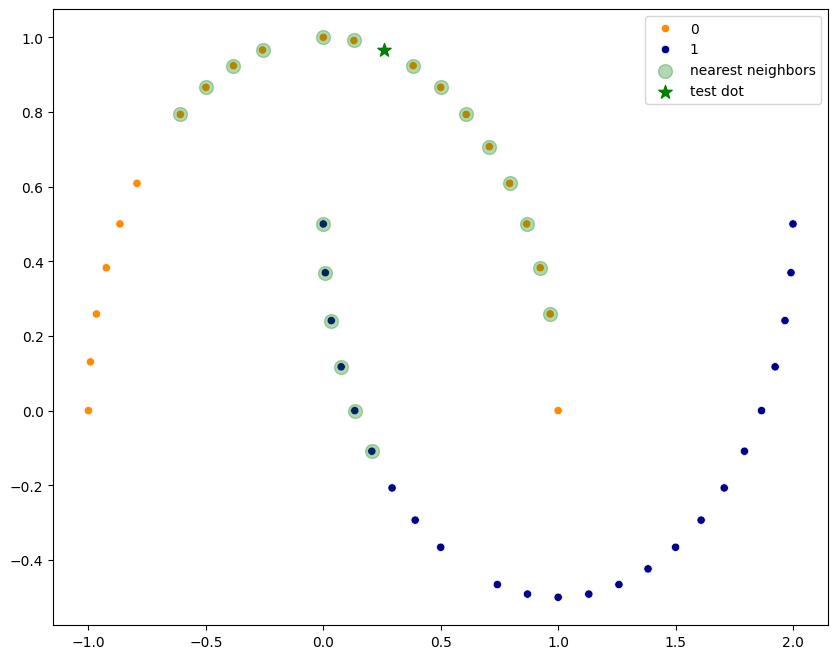

In [ ]:
# Create color maps
cmap_bold = ["darkorange", "darkblue"]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_train[:, 0],
    y=X_train[:, 1],
    hue=y_train,
    palette=cmap_bold
)

plt.scatter(X_train[nearest_neigbors_idxs, 0], X_train[nearest_neigbors_idxs, 1],
            c='g', alpha=0.3, marker='o', s=100, label='nearest neighbors')

plt.scatter(X_test[idx, 0], X_test[idx, 1], c='g', marker='*', s=100, label='test dot')
plt.legend();

А давайте возьмем еще один тестовый объект.

In [ ]:
import numpy as np
import pandas as pd

# Выбираем индекс тестовой точки
idx = 1
# Получаем тестовую точку по выбранному индексу
test_dot = X_test[idx]

# Создаем список для хранения данных о расстояниях
distances_data = []

# Проходим по всем точкам обучающего набора
for i, train_dot in enumerate(X_train):
    # Вычисляем евклидово расстояние между тестовой и обучающей точкой
    distance = np.linalg.norm(train_dot - test_dot, ord=2)
    # Добавляем индекс точки, расстояние и метку в список
    distances_data.append({
        'train_idx': i,
        'dst': distance,
        'label': y_train[i]
    })

# Создаем DataFrame из списка данных
distances = pd.DataFrame(distances_data)

In [ ]:
nearest_neigbors_idxs = distances.sort_values('dst').head(n_neighbors).index
nearest_neigbors_idxs

Index([22, 23, 33, 42, 24, 32, 2, 27, 1, 13, 19, 35, 29, 3, 10, 38, 30, 43, 37,
       14],
      dtype='int64')

А вот здесь не повезло, т.к. наши 20 ближайших соседей в большинстве своем являются представителями синего класса, а наш тестовый объект на самом деле оранжевый класс, так что 20 - это всё-таки многовато для нашей задачи.

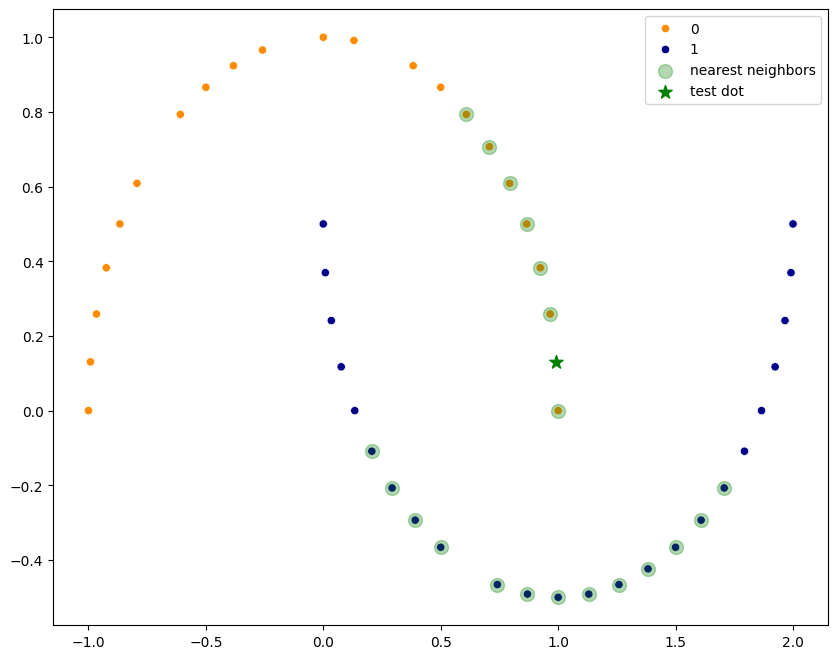

In [ ]:
# Create color maps
cmap_bold = ["darkorange", "darkblue"]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_train[:, 0],
    y=X_train[:, 1],
    hue=y_train,
    palette=cmap_bold
)

plt.scatter(X_train[nearest_neigbors_idxs, 0], X_train[nearest_neigbors_idxs, 1],
            c='g', alpha=0.3, marker='o', s=100, label='nearest neighbors')

plt.scatter(X_test[idx, 0], X_test[idx, 1], c='g', marker='*', s=100, label='test dot')
plt.legend();

Но как мы можем с этим побороться?

А можем пользоваться модификацией модели KNN - **Weighted KNN (взвешенный KNN)**

### Взвешенный KNN

По дефолту модель с `sklearn` обучается с атрибутом `weights=uniform` - это значит, что каждый сосед одинаково важен и одинаково влияет на финальное предсказание модели.

In [ ]:
KNeighborsClassifier?

Но мы можем это поменять и сделать каких-то соседей более значимыми, а каких-то менее, для этого атрибут `weights` поменяем на `distance`.

В этом случае веса будут обратными расстоянию до объектов с обучения.

Можем привести пример на наших 20 соседях.

In [ ]:
n_neighbors = 20
model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')

In [ ]:
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20, weights='distance')

In [ ]:
pred_test = model.predict(X_test)
display(pred_test, y_test)

array([0, 0, 0, 0, 1])

array([0, 0, 0, 0, 1])

А вот теперь всё совпало.


#### Детали получения предсказания в KNN

Возьмем тот объект, где была ошибка.

In [ ]:
import numpy as np
import pandas as pd

# Выбираем индекс тестовой точки
idx = 1
# Получаем тестовую точку по выбранному индексу
test_dot = X_test[idx]

# Создаем список для хранения данных о расстояниях
distances_data = []

# Проходим по всем точкам обучающего набора
for i, train_dot in enumerate(X_train):
    # Вычисляем евклидово расстояние между тестовой и обучающей точкой
    distance = np.linalg.norm(train_dot - test_dot, ord=2)
    # Добавляем индекс точки, расстояние и метку в список
    distances_data.append({
        'train_idx': i,
        'dst': distance,
        'label': y_train[i]
    })

# Создаем DataFrame из списка данных
distances = pd.DataFrame(distances_data)

In [ ]:
nearest_neigbors_idxs = distances.sort_values('dst').head(n_neighbors).index
nearest_neigbors_idxs

Index([22, 23, 33, 42, 24, 32, 2, 27, 1, 13, 19, 35, 29, 3, 10, 38, 30, 43, 37,
       14],
      dtype='int64')

Все те же самые соседи, но теперь те, кто находятся далеко влияют меньше, а те, кто близко влияют больше.

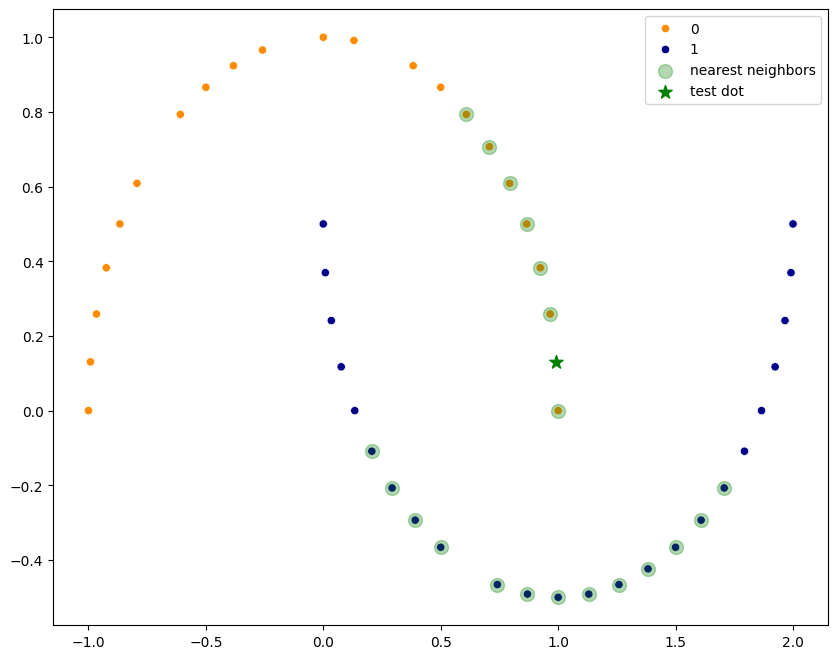

In [ ]:
# Create color maps
cmap_bold = ["darkorange", "darkblue"]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_train[:, 0],
    y=X_train[:, 1],
    hue=y_train,
    palette=cmap_bold
)

plt.scatter(X_train[nearest_neigbors_idxs, 0], X_train[nearest_neigbors_idxs, 1],
            c='g', alpha=0.3, marker='o', s=100, label='nearest neighbors')

plt.scatter(X_test[idx, 0], X_test[idx, 1], c='g', marker='*', s=100, label='test dot')
plt.legend();

Можем рассчитать вес каждого соседа, для этого 1 поделим на расстояние до объекта.

In [ ]:
distances['weight'] = 1 / distances['dst']
distances = distances.sort_values('dst').head(n_neighbors)
distances

,train_idx,dst,label,weight
22,22,0.130806,0,7.644894
23,23,0.130806,0,7.644894
33,33,0.261052,0,3.830649
42,42,0.390181,0,2.562915
24,24,0.517638,0,1.931852
32,32,0.630584,1,1.585831
2,2,0.633818,1,1.577741
27,27,0.637332,1,1.569042
1,1,0.642879,0,1.555503
13,13,0.646828,1,1.546005


<ipython-input-60-bc6cbb17cb7b>:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(x, 1/(x))


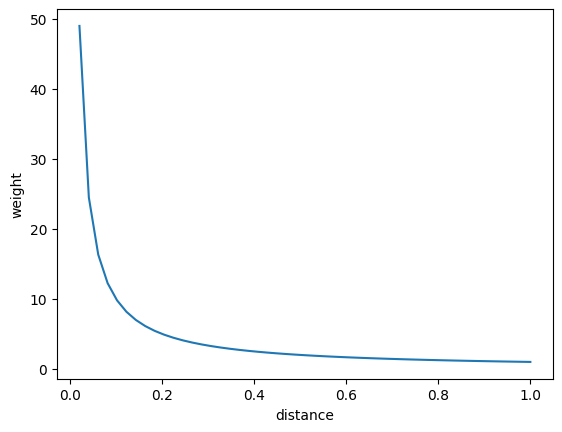

In [ ]:
x = np.linspace(0, 1, 50)
plt.plot(x, 1/(x))
plt.ylabel('weight')
plt.xlabel('distance');

Зная вес каждого соседа, можем посчитать взвешенную сумму и где сумма весов будет больше, тот класс и наше финальное предсказание.

Победил нулевой класс - а это наш оранжевый.

In [ ]:
display(f"Вес для класса 0 - {distances[distances['label'] == 0]['weight'].sum()}",
        f"Вес для класса 1 - {distances[distances['label'] == 1]['weight'].sum()}")

'Вес для класса 0 - 26.477269988013717'

'Вес для класса 1 - 18.588307260356473'

Получаем, что по обычному большинству побеждал первый класс, а по весу побеждает нулевой класс, т.к. не все объекты активно участвуют в голосовании.

In [ ]:
distances['label'].value_counts()

,count
label,
1,13
0,7


И можем с помощью визуализации отрисовать важность соседей.

Те, кто ближе имеют полузеленую окружность больше, а те, кто дальше имеют маленькую окружность.

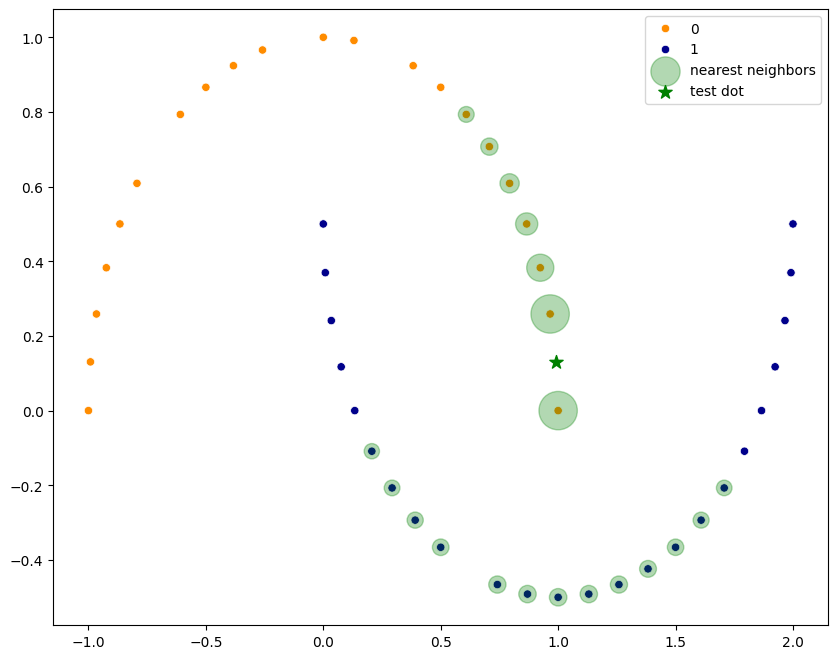

In [ ]:
# Create color maps
cmap_bold = ["darkorange", "darkblue"]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_train[:, 0],
    y=X_train[:, 1],
    hue=y_train,
    palette=cmap_bold
)

plt.scatter(X_train[nearest_neigbors_idxs, 0], X_train[nearest_neigbors_idxs, 1],
            c='g', alpha=0.3, marker='o', s=distances['weight']*100, label='nearest neighbors')

plt.scatter(X_test[idx, 0], X_test[idx, 1], c='g', marker='*', s=100, label='test dot')
plt.legend();

#### Резюме взвешенного KNN


На **моменте обучения** ничего интересного не происходит: все точки из обучения попросту запоминаются.

На **моменте предсказания**:
1. для тестовой точки считаем расстояния до всех точек с обучения
2. сортируем от самого ближнего до самого дальнего расстояния
3. считаем веса для ближайших $N$ соседей
4. суммируем веса для каждого класса, где максимальная сумма - это предсказанная метка класса

## Зачем нужен взвешенный KNN для регрессии

А теперь давайте обсудим, чем может быть полезен KNN для регрессии.

Но для начала давайте быстро вспомним, в чем суть модели *KNN* для этой задачи.

- Обучения нет, модель запоминает обучающую выборку
- На моменте предсказания
    1. Считаем **расстояния** до всех объектов с **обучения**
    2. Выбираем **K** ближайших
    3. Делаем **усреднение** между соседами


 <img src='https://drive.google.com/uc?id=1ABbqUeWI0vpWslGm_cBw-wWe5TpWxV6D' width=500>


Давайте обучим модель KNN для регресии из `sklearn` на сгенерированных данных.

Сгенерируем 50 объектов с помощью придуманной функции.

In [ ]:
from sklearn.datasets import make_regression
import numpy as np
np.random.seed(8)  # Устанавливаем зерно генератора случайных чисел для воспроизводимости результатов

# Определяем нелинейную функцию для генерации целевых значений
def func(x):
    return 0.03*x**3 + 0.2*x**2

# Генерируем входные признаки (X) как линейное пространство от -10 до 10
X = np.linspace(-10, 10, 50).reshape(-1, 1)

# Генерируем целевые значения (y) используя нелинейную функцию и добавляем случайный шум
y = func(X) + np.random.randn(50, 1)

# Отображаем сгенерированные признаки и целевые значения
display(X, y)

array([[-10.        ],
       [ -9.59183673],
       [ -9.18367347],
       [ -8.7755102 ],
       [ -8.36734694],
       [ -7.95918367],
       [ -7.55102041],
       [ -7.14285714],
       [ -6.73469388],
       [ -6.32653061],
       [ -5.91836735],
       [ -5.51020408],
       [ -5.10204082],
       [ -4.69387755],
       [ -4.28571429],
       [ -3.87755102],
       [ -3.46938776],
       [ -3.06122449],
       [ -2.65306122],
       [ -2.24489796],
       [ -1.83673469],
       [ -1.42857143],
       [ -1.02040816],
       [ -0.6122449 ],
       [ -0.20408163],
       [  0.20408163],
       [  0.6122449 ],
       [  1.02040816],
       [  1.42857143],
       [  1.83673469],
       [  2.24489796],
       [  2.65306122],
       [  3.06122449],
       [  3.46938776],
       [  3.87755102],
       [  4.28571429],
       [  4.69387755],
       [  5.10204082],
       [  5.51020408],
       [  5.91836735],
       [  6.32653061],
       [  6.73469388],
       [  7.14285714],
       [  7

array([[-9.90879528e+00],
       [-6.98247905e+00],
       [-8.31549023e+00],
       [-6.25838414e+00],
       [-5.86855764e+00],
       [-4.65401665e-02],
       [ 2.15116128e-01],
       [ 1.47569331e+00],
       [ 7.02264167e-01],
       [ 1.38483936e+00],
       [-3.97105122e-01],
       [ 2.96975123e+00],
       [ 9.85280388e-02],
       [ 6.39928015e-01],
       [ 9.33594782e-01],
       [ 4.66448970e-01],
       [ 2.01408406e+00],
       [ 7.82819280e-01],
       [ 7.81859988e-01],
       [ 4.59877735e-01],
       [ 1.83569550e+00],
       [-2.86253089e-01],
       [ 2.12387622e-03],
       [ 4.92135298e-01],
       [-1.63791524e+00],
       [-4.74956092e-01],
       [ 6.17321899e-01],
       [ 1.40626152e+00],
       [ 6.57309931e-01],
       [ 1.87776873e-01],
       [ 2.78983690e+00],
       [ 1.74649192e+00],
       [ 2.76609419e+00],
       [ 3.84205420e+00],
       [ 4.69316779e+00],
       [ 5.49341696e+00],
       [ 7.98354952e+00],
       [ 8.02588219e+00],
       [ 1.0

Разобьем выборку на обучение и тест с помощью `train_test_split`.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, test_size=5)
X_train.shape, X_test.shape

((45, 1), (5, 1))

И отрисуем полученные точки.

А зеленые звезды - это тестовые точки, для них будет искать ближайших соседей.

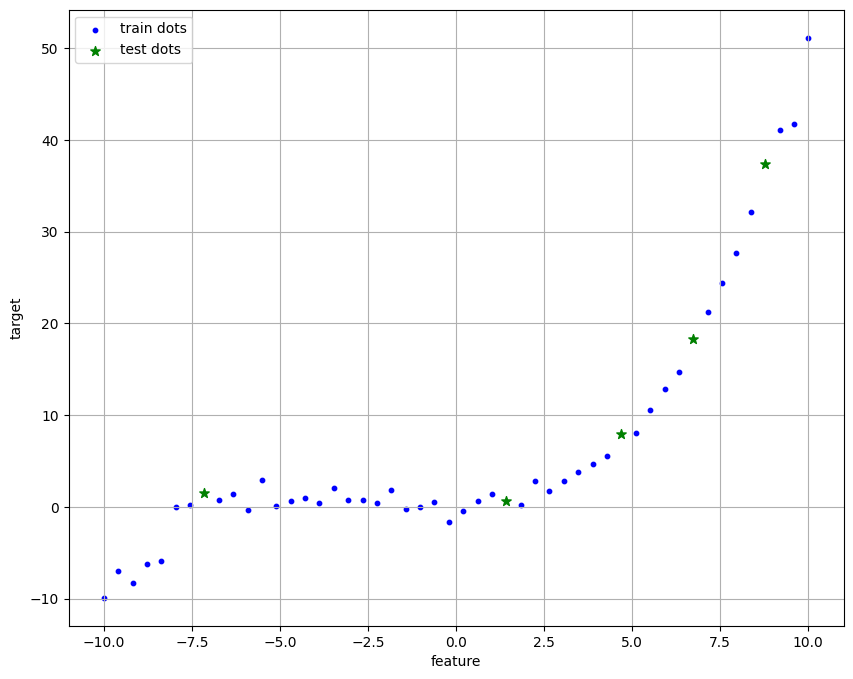

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.scatter(X_train, y_train, c='b', marker='o', s=10, label='train dots')
plt.scatter(X_test, y_test, c='g', marker='*', s=50, label='test dots')
plt.grid()
plt.ylabel('target')
plt.xlabel('feature')
plt.legend();

Инициализируем модель `KNeighborsRegressor` для задачи регрессии из `sklearn`.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

n_neighbors = 20
model = KNeighborsRegressor(n_neighbors=n_neighbors)

In [ ]:
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20)

И теперь можем сделать предсказания для наших тестовых объектов.

In [ ]:
pred_test = model.predict(X_test)
pred_test

array([[ 2.80737304],
       [15.45383115],
       [-1.22462722],
       [15.45383115],
       [10.70420217]])

И посчитаем [метрику качества](https://yandex.ru/search/?text=%D0%BA%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82+%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8+%D1%84%D0%BE%D1%80%D0%BC%D1%83%D0%BB%D0%B0&lr=213&src=suggest_B#:~:text=How%20to%20Calculate%20the%20Coefficient%20of%20Determination%3F%20%2D%20GeeksforGeeks). Она совсем печальная.

Видимо 20 соседей - это многовато для наших данных.

In [ ]:
from sklearn.metrics import r2_score #коэффициент детерминации (R2 = 1 - (mse_model / mse_mean) )

r2_score(pred_test, y_test) # Чем меньше средняя квдратичная ошибка, тем R2 больше (ближе к единице), тем выше качество модели.
                            # Если R2 отрицательна, то модель работает хуже, чем простой подсчет среднего.
                            # Если R2 = 0, модель работает так же, как среднее

-1.22454737493758

#### Детали получения предсказания в KNN

Давайте посмотрим на ближайших соседей для пары тестовых объектов.

Для этого
1. пройдемся по всем обучающим объектам
2. посчитаем Евклидово расстояние (ведь именно оно и считается по умолчанию в KNN в `sklearn`) через `numpy.linalg.norm`.

In [ ]:
import numpy as np
import pandas as pd

# Выбираем индекс тестовой точки
idx = 0
# Получаем тестовую точку из тестового набора данных
test_dot = X_test[idx]

# Создаем список для хранения данных о расстояниях
distances_data = []

# Проходим по всем точкам обучающего набора
for i, train_dot in enumerate(X_train):
    # Вычисляем евклидово расстояние между тестовой и обучающей точкой
    distance = np.linalg.norm(train_dot - test_dot, ord=2)
    # Добавляем индекс точки и расстояние в список
    distances_data.append({
        'train_idx': i,
        'dst': distance
    })

# Создаем DataFrame из списка данных
distances = pd.DataFrame(distances_data)

И получим их индексы для дальнейшей отрисовки.

In [ ]:
nearest_neigbors_idxs = distances.sort_values('dst').head(n_neighbors).index
nearest_neigbors_idxs

Index([0, 43, 23, 11, 9, 34, 17, 19, 13, 21, 37, 33, 1, 20, 15, 7, 3, 27, 6,
       5],
      dtype='int64')

Отрисовываем 20 найденных соседей в полупрозрачные зеленые окружности.

Чтобы получить предсказания для тестового объекта, нужно усреднить целевые значения ближайших соседей.

И видим, что наше предсказание в целом-то походит на правду.

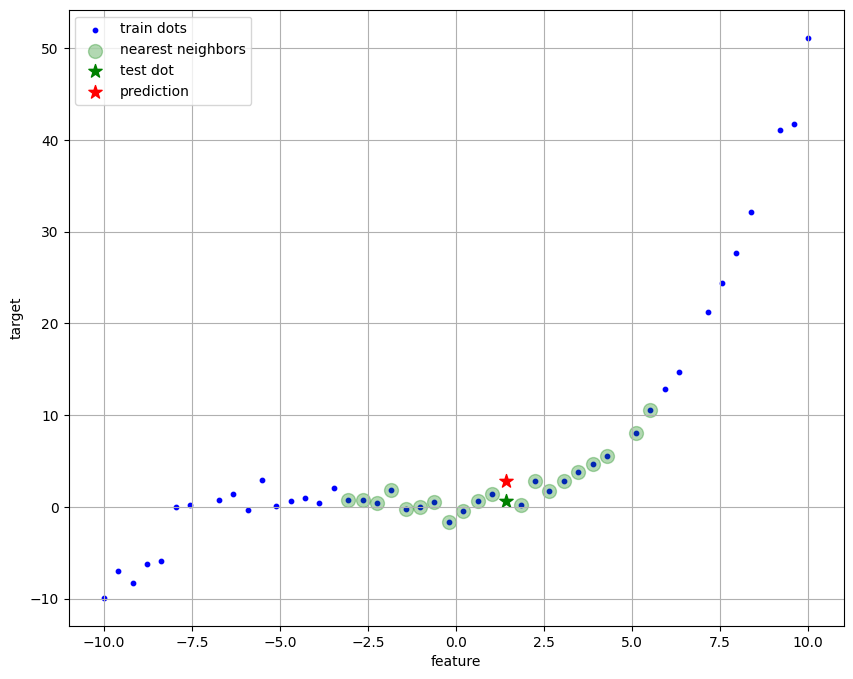

In [ ]:
plt.figure(figsize=(10, 8))

plt.scatter(X_train, y_train, c='b', marker='o', s=10, label='train dots')
plt.grid()

plt.scatter(X_train[nearest_neigbors_idxs], y_train[nearest_neigbors_idxs],
            c='g', alpha=0.3, marker='o', s=100, label='nearest neighbors')

plt.scatter(X_test[idx, 0], y_test[idx], c='g', marker='*', s=100, label='test dot')
plt.scatter(X_test[idx, 0], pred_test[idx], c='r', marker='*', s=100, label='prediction')

plt.xlabel('feature')
plt.ylabel('target')
plt.legend();

А давайте возьмем еще один тестовый объект и сделаем для него точно такие же действия.

In [ ]:
import numpy as np
import pandas as pd

# Выбираем индекс тестовой точки
idx = 1
# Получаем тестовую точку из тестового набора данных
test_dot = X_test[idx]

# Создаем список для хранения данных о расстояниях
distances_data = []

# Проходим по всем точкам обучающего набора
for i, train_dot in enumerate(X_train):
    # Вычисляем евклидово расстояние между тестовой и обучающей точкой
    distance = np.linalg.norm(train_dot - test_dot, ord=2)
    # Добавляем индекс точки и расстояние в список
    distances_data.append({
        'train_idx': i,
        'dst': distance
    })

# Создаем DataFrame из списка данных
distances = pd.DataFrame(distances_data)

In [ ]:
nearest_neigbors_idxs = distances.sort_values('dst').head(n_neighbors).index
nearest_neigbors_idxs

Index([14, 39, 25, 2, 32, 29, 18, 28, 26, 6, 7, 20, 33, 13, 19, 9, 23, 0, 43,
       11],
      dtype='int64')

Отрисовываем 20 найденных соседей в полупрозрачные зеленые окружности.

Вот здесь уже не совпадаем даже на чуть-чуть, предсказание очень сильно отличается от истины, а значит все-таки 20 соседей - это перебор.

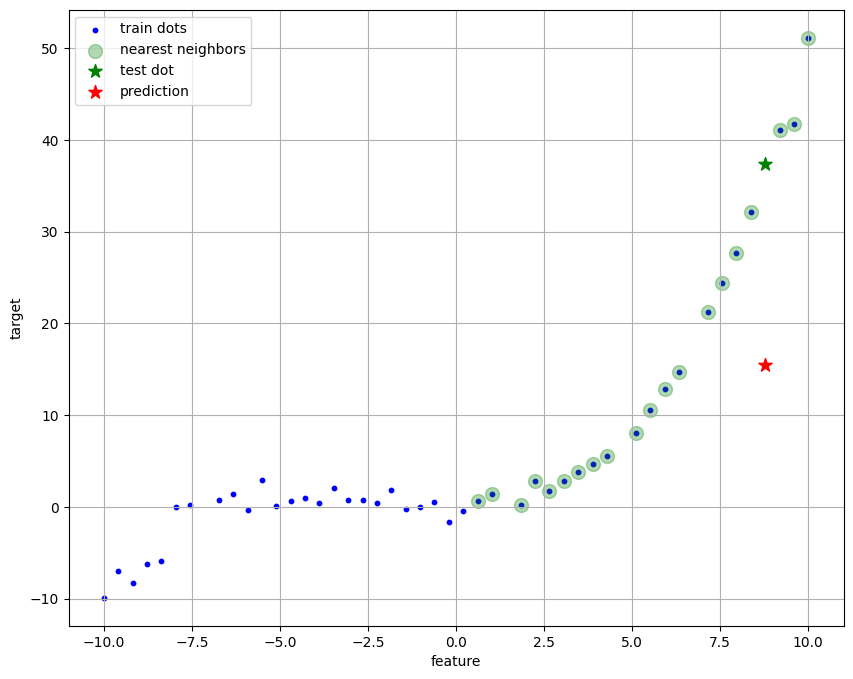

In [ ]:
plt.figure(figsize=(10, 8))

plt.scatter(X_train, y_train, c='b', marker='o', s=10, label='train dots')
plt.grid()

plt.scatter(X_train[nearest_neigbors_idxs], y_train[nearest_neigbors_idxs],
            c='g', alpha=0.3, marker='o', s=100, label='nearest neighbors')

plt.scatter(X_test[idx, 0], y_test[idx], c='g', marker='*', s=100, label='test dot')
plt.scatter(X_test[idx, 0], pred_test[idx], c='r', marker='*', s=100, label='prediction')

plt.xlabel('feature')
plt.ylabel('target')

plt.legend();

Давайте снова с этим бороться с помощью **Weighted KNN (взвешенный KNN)**

### Взвешенный KNN

Вспомним, что по умолчанию модель с `sklearn` обучается с атрибутом `weights=uniform` - это значит, что каждый сосед одинаково важен и одинаково влияет на финальное предсказание модели.

In [ ]:
KNeighborsRegressor?

Но мы можем это поменять и сделать каких-то соседей более значимыми, а каких-то менее, для этого атрибут `weights` поменяем на `distance`.

В этом случае веса будут обратными расстоянию до объектов с обучения.

In [ ]:
n_neighbors = 20
model = KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance')

In [ ]:
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20, weights='distance')

In [ ]:
prev_pred_test = pred_test.copy()

In [ ]:
pred_test = model.predict(X_test)
r2_score(pred_test, y_test)

0.8683987446927024

Метрика стала гораздо лучше, а всего лишь изменили способ подсчета ближайших соседей.

#### Детали получения предсказания в KNN

Возьмем тот объект, где была ошибка.

In [ ]:
import numpy as np
import pandas as pd

# Выбираем индекс тестовой точки
idx = 1
# Получаем тестовую точку из тестового набора данных
test_dot = X_test[idx]

# Создаем список для хранения данных о расстояниях
distances_data = []

# Проходим по всем точкам обучающего набора
for i, train_dot in enumerate(X_train):
    # Вычисляем евклидово расстояние между тестовой и обучающей точкой
    distance = np.linalg.norm(train_dot - test_dot, ord=2)
    # Добавляем индекс точки, расстояние и метку в список
    distances_data.append({
        'train_idx': i,
        'dst': distance,
        'label': y_train[i][0]  # Предполагаем, что y_train - это двумерный массив
    })

# Создаем DataFrame из списка данных
distances = pd.DataFrame(distances_data)

In [ ]:
nearest_neigbors_idxs = distances.sort_values('dst').head(n_neighbors).index
nearest_neigbors_idxs

Index([14, 39, 25, 2, 32, 29, 18, 28, 26, 6, 7, 20, 33, 13, 19, 9, 23, 0, 43,
       11],
      dtype='int64')

Все те же самые соседи, но предсказание сейчас гораздо лучше, ведь теперь те соседи, которые находятся далеко влияют меньше, а те, кто близко влияют больше.

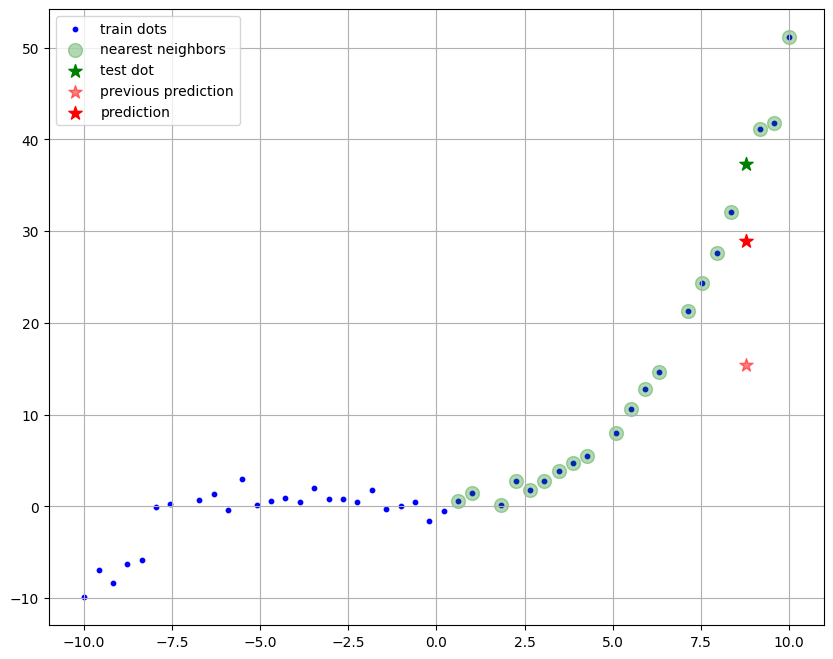

In [ ]:
plt.figure(figsize=(10, 8))

plt.scatter(X_train, y_train, c='b', marker='o', s=10, label='train dots')
plt.grid()

plt.scatter(X_train[nearest_neigbors_idxs], y_train[nearest_neigbors_idxs],
            c='g', alpha=0.3, marker='o', s=100, label='nearest neighbors')

plt.scatter(X_test[idx, 0], y_test[idx], c='g', marker='*', s=100, label='test dot')
plt.scatter(X_test[idx, 0], prev_pred_test[idx][0], c='r', alpha=0.5, marker='*', s=100, label='previous prediction')
plt.scatter(X_test[idx, 0], pred_test[idx], c='r', marker='*', s=100, label='prediction')

plt.legend();

Можем рассчитать вес каждого соседа, для этого 1 поделим на расстояние до объекта.

In [ ]:
distances['weight'] = 1 / (distances['dst'])
distances = distances.sort_values('dst').head(n_neighbors)
distances

,train_idx,dst,label,weight
14,14,0.408163,41.110557,2.450000
39,39,0.408163,32.127914,2.450000
25,25,0.816327,27.640171,1.225000
2,2,0.816327,41.740175,1.225000
32,32,1.224490,51.139534,0.816667
29,29,1.224490,24.395433,0.816667
18,18,1.632653,21.280717,0.612500
28,28,2.448980,14.667229,0.408333
26,26,2.857143,12.815946,0.350000
6,6,3.265306,10.590643,0.306250


<ipython-input-91-f08958cd4bec>:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(x, 1/(x))


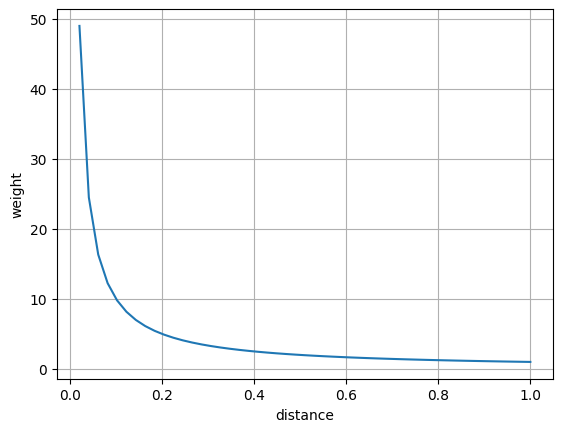

In [ ]:
x = np.linspace(0, 1, 50)
plt.plot(x, 1/(x))
plt.grid()
plt.ylabel('weight')
plt.xlabel('distance');

Зная вес каждого соседа, можем посчитать нормированную взвешенную сумму предсказания.


In [ ]:
(distances['label'] * distances['weight']).sum() / distances['weight'].sum()

28.905126006757015

In [ ]:
y_test[idx]

array([37.3778963])

Получаем, что по обычному большинству предсказание было слишком маленькое, из-за того, что есть точки с маленькими значениями и их больше, но они расположены дальше.

In [ ]:
prev_pred_test[idx]

array([15.45383115])

А с помощью весов предсказание получилось гораздо лучше, ведь те объекты, которые расположены далеко и имеют маленькие целевые значения, теперь влияют не так сильно.

In [ ]:
pred_test[idx]

array([28.90512601])

И можем с помощью визуализации отрисовать важность соседей.

Те, кто ближе имеют полузеленую окружность больше, а те, кто дальше имеют маленькую окружность.

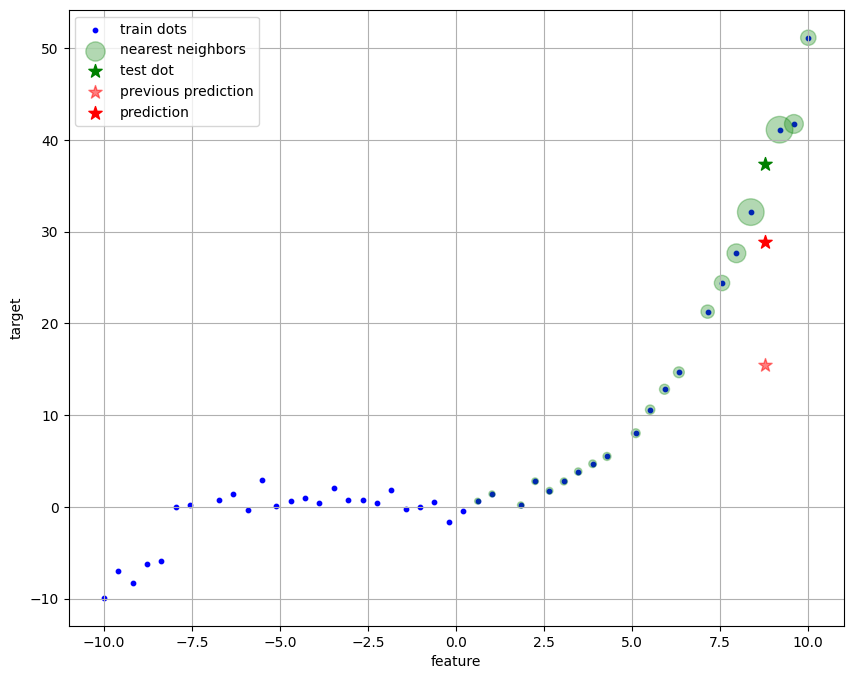

In [ ]:
plt.figure(figsize=(10, 8))

plt.scatter(X_train, y_train, c='b', marker='o', s=10, label='train dots')
plt.grid()

plt.scatter(X_train[nearest_neigbors_idxs], y_train[nearest_neigbors_idxs],
            c='g', alpha=0.3, marker='o', s=distances['weight']*150, label='nearest neighbors')

plt.scatter(X_test[idx, 0], y_test[idx], c='g', marker='*', s=100, label='test dot')
plt.scatter(X_test[idx, 0], prev_pred_test[idx][0], c='r', alpha=0.5, marker='*', s=100, label='previous prediction')
plt.scatter(X_test[idx, 0], pred_test[idx], c='r', marker='*', s=100, label='prediction')

plt.xlabel('feature')
plt.ylabel('target')

plt.legend();

#### Резюме взвешенного KNN


На **моменте обучения** ничего интересного не происходит: все точки из обучения попросту запоминаются.

На **моменте предсказания**:
1. для тестовой точки считаем расстояния до всех точек с обучения
2. сортируем от самого ближнего до самого дальнего расстояния
3. считаем веса для ближайших $N$ соседей
4. умножаем веса на таргеты соседей
5. суммируем перемножения
6. нормируем на сумму весов

## Callable объект в атрибут weights

С взвешенными KNN для регрессии и классификации разобрались, теперь можем поговорить, а какие еще веса можем использовать для модели.

А на самом деле мы не ограничиваемся значениями `uniform` и `distance` в атрибуте `weights`, мы можем написать свою кастомную функцию для подсчета весов.



К примеру, давайте реализуем аналог `distance`.

На вход эта функция должна принимать массив дистанций и выдавать массив весов.

In [ ]:
def calc_weight_distance(dists):
    return 1 / dists

Теперь эту функцию можем передать в атрибут `weights`.

In [ ]:
n_neighbors = 20
model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=calc_weight_distance)

In [ ]:
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20,
                    weights=<function calc_weight_distance at 0x77ffa63ecc10>)

И убедимся, что предсказания и метрики получаются идентичными.

Для справки (вот такая метрика была на KNN из `sklearn`)
```
0.8683987446927024
```

In [ ]:
pred_test = model.predict(X_test)
r2_score(pred_test, y_test)

0.8683987446927024

Можем реализовать немного другую функцию подсчета весов.

In [ ]:
def calc_weight_distance_2(dists):
    return 0.5 ** dists

Теперь эту функцию можем передать в атрибут `weights`.

In [ ]:
n_neighbors = 20
model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=calc_weight_distance_2)

In [ ]:
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20,
                    weights=<function calc_weight_distance_2 at 0x77ffa63ece50>)

И посмотрим, что стало с метрикой.

А так вышло, что она стала выше. Значит данный метод рассчета весов подходит для этой задачи больше.

In [ ]:
pred_test = model.predict(X_test)
r2_score(pred_test, y_test)

0.9369864623634033

Давайте в целом посмотрим, какие виды функций можно использовать для подсчета весов:

### От расстояния $d$

#### a)   $$w(d) = q^{d},   q \in (0,1);$$



#### Параметры функции:
- $w(d)$ - это весовая функция, зависящая от расстояния $d$
- $q$ - это параметр, который находится в интервале от 0 до 1 (не включая границы)
- $d$ - это расстояние между точками

#### Интерпретация:
1. Чем больше расстояние $d$, тем меньше будет значение $w(d)$, так как $q < 1$.
2. При $d = 0$ (точки совпадают), вес будет максимальным и равным 1.
3. При увеличении $d$ вес будет экспоненциально уменьшаться.

#### Применение в kNN:
- Эта функция позволяет придавать большее значение ближайшим соседям и меньшее - дальним.
- Выбор параметра $q$ влияет на скорость убывания веса с расстоянием.

#### Пример:
Если $q = 0.5$ и $d = 2$, то $w(2) = 0.5^2 = 0.25$. Это означает, что точка на расстоянии 2 будет иметь вес 0.25.

Использование такой весовой функции может улучшить точность предсказаний kNN, особенно в случаях, когда ближайшие соседи более информативны, чем дальние.

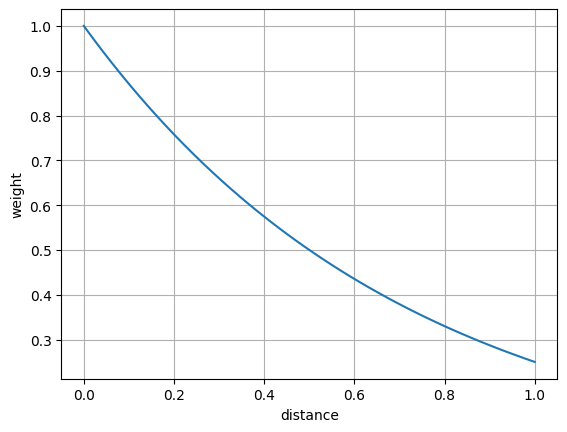

In [ ]:
q = 0.25
x = np.linspace(0, 1, 50)
plt.plot(x, q ** x)
plt.xlabel('distance')
plt.ylabel('weight')
plt.grid();

#### б) $$w(d) = \frac{1}{d+a}$$

#### Компоненты функции:
- $w(d)$ - это весовая функция, зависящая от расстояния $d$
- $d$ - это расстояние между точками
- $a$ - это параметр, который добавляется к расстоянию

#### Интерпретация:
1. Эта функция обратно пропорциональна расстоянию: чем больше расстояние, тем меньше вес.
2. Параметр $a$ добавлен для решения проблемы деления на ноль при $d = 0$.
3. При $d = 0$, вес будет равен $\frac{1}{a}$, что предотвращает получение бесконечно большого веса.

#### Преимущества:
1. Функция плавно убывает с увеличением расстояния, что интуитивно понятно.
2. Параметр $a$ позволяет настраивать чувствительность функции к малым расстояниям.

#### Применение в kNN:
- Эта функция позволяет придавать большее значение ближайшим соседям и меньшее - дальним.
- Выбор параметра $a$ влияет на то, насколько резко уменьшается вес с увеличением расстояния.

#### Сравнение с $\frac{1}{d}$:
Использование $\frac{1}{d}$ проблематично из-за деления на ноль при $d = 0$. Добавление $a$ в знаменатель решает эту проблему.

#### Подход sklearn:
В библиотеке sklearn используется другой подход для случая $d = 0$:
- Если расстояние равно 0, объекту присваивается вес 1.
- Всем остальным объектам присваивается вес 0.

Этот подход эффективен, когда есть точное совпадение с одним из обучающих примеров, но может быть менее гибким в некоторых ситуациях по сравнению с функцией $\frac{1}{d+a}$.

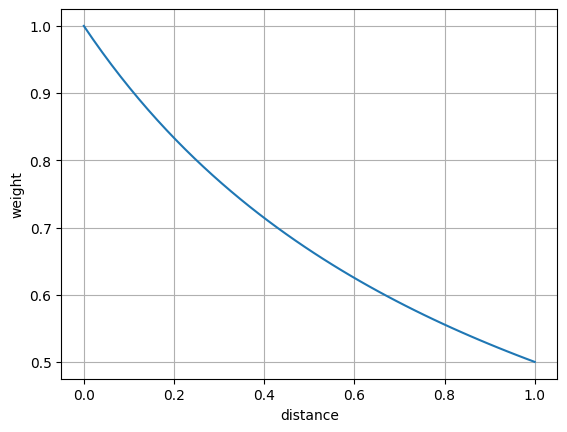

In [ ]:
a = 1
x = np.linspace(0, 1, 50)
plt.plot(x, 1 / (x + a))
plt.xlabel('distance')
plt.ylabel('weight')
plt.grid();

### От номера соседа $i$

#### а) $$w(i) = q^{i},   q \in (0,1)$$;


#### Параметры функции:
- $w(i)$ - это весовая функция, зависящая от индекса или ранга $i$
- $q$ - это параметр, который находится в интервале от 0 до 1 (не включая границы)
- $i$ - это индекс или ранг соседа (обычно начиная с 0 или 1)

#### Интерпретация:
1. Чем больше индекс $i$, тем меньше будет значение $w(i)$, так как $q < 1$.
2. При $i = 0$, вес будет максимальным и равным 1.
3. С увеличением $i$ вес будет экспоненциально уменьшаться.

#### Применение в kNN:
- Эта функция позволяет придавать большее значение ближайшим соседям и меньшее - дальним.
- В контексте kNN, $i$ может представлять ранг соседа по близости к тестовой точке.

#### Свойства:
1. Монотонное убывание: вес строго уменьшается с увеличением $i$.
2. Ограниченность: веса всегда находятся в интервале (0, 1].
3. Сумма весов сходится: $\sum_{i=0}^{\infty} q^i = \frac{1}{1-q}$ для $q < 1$.

#### Выбор параметра $q$:
- Меньшие значения $q$ приводят к более быстрому убыванию весов.
- Большие значения $q$ (ближе к 1) дают более равномерное распределение весов.

In [ ]:
q = 0.5
x = np.linspace(1, 51, 50)
plt.plot(x, q ** x)
plt.xlabel('n')
plt.ylabel('weight')
plt.grid();

#### б) $$w(i) = \frac{1}{i}$$


#### Параметры функции:
- $w(i)$ - это весовая функция, зависящая от индекса или ранга $i$
- $i$ - это индекс или ранг соседа (обычно начиная с 1)

#### Интерпретация:
1. Чем больше индекс $i$, тем меньше будет значение $w(i)$.
2. Вес обратно пропорционален индексу.
3. При $i = 1$ (ближайший сосед) вес будет максимальным и равным 1.

#### Применение в kNN:
- Эта функция позволяет придавать большее значение ближайшим соседям и меньшее - дальним.
- В контексте kNN, $i$ обычно представляет ранг соседа по близости к тестовой точке.

#### Свойства:
1. Монотонное убывание: вес строго уменьшается с увеличением $i$.
2. Гиперболическое убывание: вес убывает медленнее, чем в экспоненциальной функции.
3. Сумма весов расходится: $\sum_{i=1}^{\infty} \frac{1}{i}$ - это расходящийся гармонический ряд.

#### Особенности и ограничения:
1. Проблема при $i = 0$: функция не определена для нулевого индекса, что может быть проблематично в некоторых реализациях.
2. Медленное убывание: веса убывают медленнее, чем в экспоненциальной функции, что может привести к большему влиянию дальних соседей.

#### Сравнение с другими весовыми функциями:
- По сравнению с $q^i$, эта функция обеспечивает более медленное убывание весов.
- В отличие от $\frac{1}{d+a}$, эта функция зависит от ранга, а не от абсолютного расстояния.

Использование этой весовой функции может быть предпочтительно в ситуациях, когда важно учитывать влияние большего числа соседей, но при этом сохранять значительное преимущество ближайших соседей. Однако следует быть осторожным с обработкой случая $i = 0$ и учитывать, что сумма весов может быть очень большой для большого числа соседей.

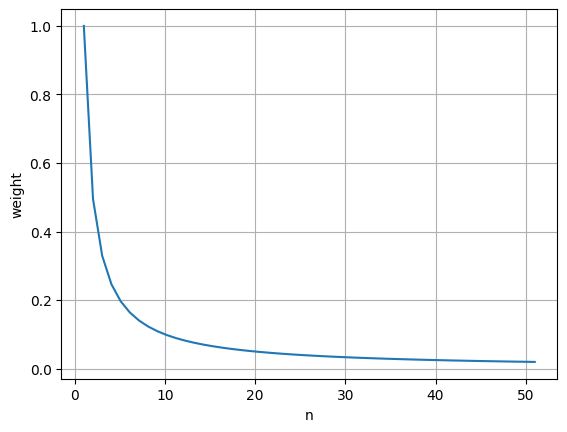

In [ ]:
x = np.linspace(1, 51, 50)
plt.plot(x, 1/x)
plt.xlabel('n')
plt.ylabel('weight')
plt.grid();

Реализуем функцию подсчета весов от номера соседа:

In [ ]:
def calc_weight_n_neigbours(dists):
    weights = np.zeros(dists.shape)

    for i in range(dists.shape[1]):
        weights[:, i] = 1/(i+1)

    return weights

Теперь эту функцию можем передать в атрибут `weights`.

In [ ]:
n_neighbors = 20
model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=calc_weight_n_neigbours)

In [ ]:
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20,
                    weights=<function calc_weight_n_neigbours at 0x77ffa46a3250>)

In [ ]:
pred_test = model.predict(X_test)
r2_score(pred_test, y_test)

0.7710471732745973

## Выводы:

1. Модель и для регрессии, и для классификации **обучается** одинаково - **никак**, она запоминает обучающую выборку.
2. Затем поступает тестовый объект и нужно сделать предсказание
    - Считаем **расстояния до** всех объектов с **обучения**
    - Выбираем **K** ближайших
    - Считаем веса для ближайших **K** соседей
    - И в зависимости от задачи выдаем финальное предсказание
        1. ***Классификация***
            - суммируем веса для каждого класса
            - максимальная сумма - это предсказанная метка класса
        2. ***Регрессия***
            - умножаем веса на таргеты соседей
            - суммируем перемножения
            - нормируем на сумму весов

### **Дополнительно:**

### **Основные параметры KNN классификатора и регрессора в scikit-learn:**

#### 1. n_neighbors (int, по умолчанию=5)
- Определяет количество ближайших соседей, учитываемых при классификации или регрессии.
- Большее значение может сгладить границы решения, но увеличивает вычислительную сложность.
- Меньшее значение может привести к переобучению, особенно на зашумленных данных.

#### 2. weights (str или callable, по умолчанию='uniform')
- 'uniform': все соседи имеют равный вес.
- 'distance': вес обратно пропорционален расстоянию до соседа.
- callable: пользовательская функция для вычисления весов.

#### 3. algorithm (str, по умолчанию='auto')
- 'auto': автоматически выбирает наиболее подходящий алгоритм.
- 'ball_tree': использует структуру данных BallTree, эффективную для высокоразмерных пространств.
- 'kd_tree': использует KDTree, эффективную для низкоразмерных пространств.
- 'brute': использует полный перебор, может быть быстрее для небольших наборов данных.

#### 4. leaf_size (int, по умолчанию=30)
- Влияет на скорость построения и запроса для 'ball_tree' и 'kd_tree'.
- Меньшие значения приводят к более быстрому запросу, но более медленному построению дерева.

#### 5. p (int, по умолчанию=2)
- Параметр степени для метрики Минковского.
- p=1 соответствует расстоянию Манхэттена, p=2 - евклидову расстоянию.

#### 6. metric (str или callable, по умолчанию='minkowski')
- Метрика для вычисления расстояний между точками.
- Можно использовать любую метрику из scipy.spatial.distance или пользовательскую функцию.

#### 7. metric_params (dict, по умолчанию=None)
- Дополнительные ключевые аргументы для функции метрики.

#### 8. n_jobs (int, по умолчанию=None)
- Количество параллельных заданий для выполнения при поиске соседей.
- None означает 1 процесс, -1 использует все доступные процессоры.

#### 9. radius (float, по умолчанию=1.0, только для RadiusNeighborsRegressor)
- Определяет радиус окрестности для поиска соседей.
- Используется вместо фиксированного числа соседей.

Выбор оптимальных значений этих параметров зависит от конкретной задачи и набора данных. Часто требуется экспериментировать и использовать методы кросс-валидации для нахождения наилучшей конфигурации.

# [Ccылка на практическую работу](https://colab.research.google.com/drive/1J71r_zp1osWMSklnnF0dx5Gpbi5d1L4v?usp=sharing)